<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Segmentación de Clientes con Clustering Jerárquico y DBSCAN

El objetivo de este caso-taller es analizar una base de datos ficticia sobre clientes de una tienda y buscar encontrar grupos de clientes que permitan generar estrategias de marketing focalizadas. La base se encuentra en los `Archivos de Laboratorio` en la carpeta `data` y cuenta con 200 observaciones y 5 variables:

- `Id_Cliente`: identificador de cliente.
- `Genero`: género del cliente: Mujer, Hombre
- `Edad`: edad en años
- `Ingreso`: ingresos anuales
- `Puntaje_Gasto`: es una variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos 

En la carpeta `data` se encuentra el archivo `datos_clientes.csv` cargue estos datos en su *cuaderno*. 

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import gower 

In [85]:
import session_info

session_info.show(html=False)

-----
gower               NA
kneed               0.8.5
matplotlib          3.8.4
numpy               1.26.4
pandas              2.2.1
scipy               1.12.0
seaborn             0.13.2
session_info        1.0.0
sklearn             1.3.0
-----
IPython             8.22.2
jupyter_client      8.6.1
jupyter_core        5.7.2
-----
Python 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.22621-SP0
-----
Session information updated at 2024-09-01 19:34


In [86]:
df_datos = pd.read_csv("./data/datos_clientes.csv")
df_datos.head()

Id_Cliente  Genero  Edad   Ingreso  Puntaje_Gasto
0           1   Mujer    41  98115.05             39
1           2   Mujer    20  35458.14             75
2           3   Mujer    68  59872.08             55
3           4  Hombre    63  48508.93             51
4           5   Mujer    31  44431.11             54

carga de datos de clientes

### 2. Análisis preliminar. 

Antes de comenzar el análisis de segmentación utilice estadísticas descriptivas para explorar la variables que se encuentran en los datos. En su análisis mencione si hay patrones que surgen del examen descriptivo de los datos; entre ellos si hay diferencias en los ingresos y los puntajes de gastos para mujeres y hombres, por grupos etarios (18-24, 25-34, 35-44, 45-54, 55-64, y 65+), y por grupos etarios y género. Discuta además si estas diferencias son estadísticamente significativas.

In [87]:
# Utilice este espacio para escribir el código.
n,v = df_datos.shape
print("cantidad de datos: {n}, cantidad de vairables: {v}".format(n=n,v=v))

cantidad de datos: 200, cantidad de vairables: 5


In [88]:
#reporte de datos nulos
df_datos.isna().sum()

Id_Cliente       0
Genero           0
Edad             0
Ingreso          0
Puntaje_Gasto    0
dtype: int64

El dataset no tiene valores nulos y cuenta con 5 variables las cuales se listan a continuacion :

* Variables Numericas
    * **Id_Cliente**: identificador unico del cliente
    * **Edad**: edad del cliente en años
    * **Ingreso**: Ingresos anuales del cliente
    * **Puntaje_Gasto**: variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.
* Variables Categoricas
    * **Genero**: valor biinario entre (Mujer, Hombre)

In [89]:
df_datos.describe()

Id_Cliente        Edad        Ingreso  Puntaje_Gasto
count  200.000000  200.000000     200.000000     200.000000
mean   100.500000   38.850000   60624.446600      50.200000
std     57.879185   13.969007   26262.903416      25.823522
min      1.000000   18.000000   13458.020000       1.000000
25%     50.750000   28.750000   41512.787500      34.750000
50%    100.500000   36.000000   60777.960000      50.000000
75%    150.250000   49.000000   77143.865000      73.000000
max    200.000000   70.000000  138584.520000      99.000000

In [90]:
# Creacion de funcion para calcular los grupos etarios
def rangos_etarios(row):
    edad = row
    if edad < 18:
        return '0. -18'
    elif edad <= 24:
        return '1. 18-24'
    elif edad <= 34:
        return '2. 25-34'
    elif edad <= 44:
        return '3. 35-44'
    elif edad <= 54:
        return '4. 45-54'
    elif edad <= 64:
        return '5. 55-64'
    elif edad >= 65:
        return '6. 65+'
    

# Aplicar la función a la columna 'Fecha de Llegada'
df_datos['rango_edades'] = df_datos['Edad'].apply(rangos_etarios)

#### Descripctiva variables generales
A continuacion la descripcion de cada variable de forma independiente

In [91]:
def describe_variables(df,variable,grupo=None):
    '''
    Funcion para dar informacion descriptiva de una variable

    parametros:
    df: dataframe de donde se quiere obtener los datos
    variable: string con el nombre de una columna del dataframe que quiere ser descrita
    grupo: string, con el nombre de otra columna del dataframe df para dar informacion agrupando por esta variable
    '''
    
    # valida si hay que agrupar 
    if grupo is None:

        # muestra informacion descriptiva
        col = variable
        display(df[[col]].describe().T)
        

        # Proceso para graficar de forma descriptiva los datos
        n_cols = 3
        n_rows = 1

        fig,ax =plt.subplots(n_rows,n_cols,figsize=(n_cols*8,n_rows*5))
        axs = ax.flatten()

        # Define la grafica de histograma
        sns.histplot(data=df, x=col, color="seagreen",ax=axs[0])
        axs[0].set_title("Histograma de la variable: {}".format(col))
        
        # Define la grafica de boxplot
        sns.boxplot(data=df, x=col, color="seagreen",ax=axs[1])
        axs[1].set_title("Boxplot de la variable {}".format(col))

        # Define la grafica de violin mas una ilustracion de la concentracion de los datos
        sns.violinplot(data=df.sort_values(by=col), x=variable,ax=axs[2], inner="quart", color="seagreen")
        sns.swarmplot(data=df.sort_values(by=col), x=variable,ax=axs[2], color="white")
        axs[2].set_title("Dispersion de la variable {}".format(col))

        plt.show()
    
    # proceso si hay que agrupar por una de las variables
    else:
    
        # define la variable a agrupar
        col = grupo
        
        #muestra valores descriptivos de la variable de entrada para cada grupo definido por la variable col
        display(df.groupby(col)[[variable]].describe())


        # obtiene los valores unicos de la categoria que agrupa y los ordena
        vars = np.sort(df_datos[col].unique())

        n_cols = 2
        n_rows = int(np.ceil((len(vars)+ 2)/n_cols)) 

        # proceso de graficar
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*15,n_rows*6.5))
        axs = ax.flatten()


        # crea un histograma por cada categoria del grupo
        for i,v in enumerate(vars):
            
            fltr = df[col] == v
            sns.histplot(data=df[fltr],x=variable, color="seagreen",ax=axs[i])
            axs[i].set_title("distribucion de variable {c} para los categoria: {i}".format(c=col, i = v))


        # genera grafica de boxplot teniendo en cuenta cada agrupacion
        sns.boxplot(data=df.sort_values(by=col), x=variable, hue=col,ax=axs[i+1], y=col, legend=True)
        axs[i+1].set_title("Boxplot de la variable {}".format(col))
        
        # genera grafica de violinplot teniendo en cuenta cada agrupacion
        sns.violinplot(data=df.sort_values(by=col), x=variable,ax=axs[i+2], y=col,hue=col, inner="quart")
        sns.swarmplot(data=df.sort_values(by=col), x=variable,ax=axs[i+2], y=col, color="white")
        axs[i+2].set_title("Dispersion de la variable {} por categorias".format(col))

    plt.show()

def describe_variables_categ(df,col,grupo=None):
    '''
    Funcion para obtener valores descriptivos de las variables categoricas

    parametros:
    df: dataframe de donde se quiere obtener los datos
    variable: string con el nombre de una columna del dataframe que quiere ser descrita
    grupo: string, con el nombre de otra columna del dataframe df para dar informacion agrupando por esta variable
    '''
    
    # Valida si tiene que agrupar
    if grupo is None:
        
        # genera el dataframe con las frecuencias para cada categoria de la variable de entrada
        gr = df.groupby(col).count()[["Id_Cliente"]]
        
        #calculo de porcentaje de cada categoria
        gr["pct"] = np.round(100*gr/gr.sum(),2)
        gr = gr.reset_index()
        display(gr)

        # Genera graficos de frecuencia
        fig,ax =plt.subplots(1,1,figsize=(8,5))
        sns.barplot(data=gr, x=col, y="Id_Cliente", color="seagreen",ax=ax ,errorbar=None)
        ax.set_title("Grafica de Barras de la variable: {}".format(col))

        plt.show()
    else:
        # genera el dataframe con las frecuencias para cada categoria agrupando por las dos variables ingresasdas como parametro
        gr = df.groupby([col,grupo]).count()[["Id_Cliente"]].reset_index()
        display(gr)
        
        # Genera graficos de frecuencia
        fig,ax =plt.subplots(1,1,figsize=(8,5))
        sns.barplot(data=gr.sort_values(by=col), x=col, y="Id_Cliente", color="seagreen",ax=ax, hue=grupo, errorbar=None)
        ax.set_title("Grafica de Barras de la variable {a}, agrupada por {b}".format(a=col, b = grupo))

        plt.show()

##### Variable Edad

count   mean        std   min    25%   50%   75%   max
Edad  200.0  38.85  13.969007  18.0  28.75  36.0  49.0  70.0

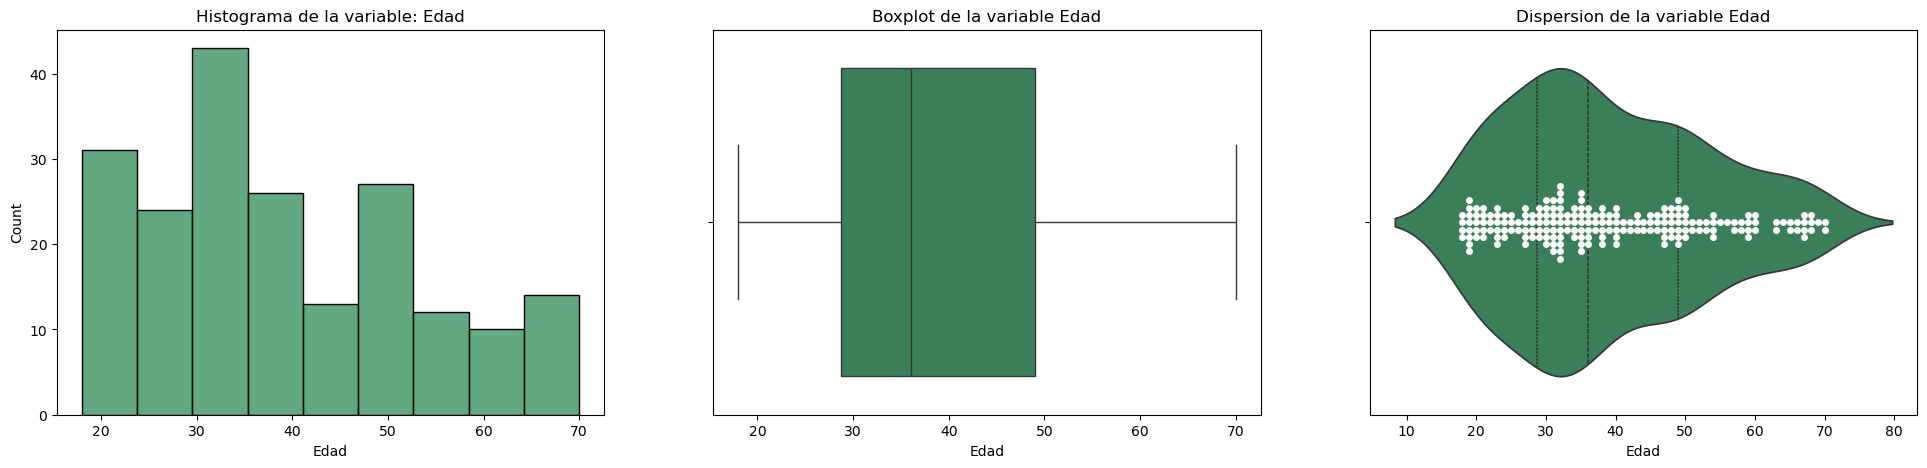

In [92]:
describe_variables(df_datos,variable="Edad")

En la variable edad se ve que la edad minima es de 18 años, la maxima de 70 años y en promedio la edad es de aprox 39 años, con las distribuciones se observa que las edades estan mas concentradas entre los 30 - 40 años

##### Variable rango por edades

rango_edades  Id_Cliente   pct
0     1. 18-24          35  17.5
1     2. 25-34          54  27.0
2     3. 35-44          42  21.0
3     4. 45-54          39  19.5
4     5. 55-64          16   8.0
5       6. 65+          14   7.0

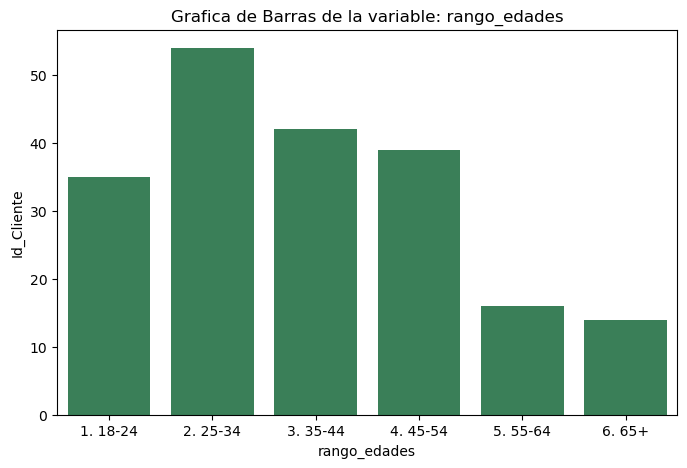

In [93]:
describe_variables_categ(df_datos, col="rango_edades")

para los rangos de edades definidos se ve que la concentracion de datos esta en edades menores a 55 años, siendo el rango de 25-34 años el de mayor concentracion

##### Variable Ingreso

count        mean           std       min         25%       50%  \
Ingreso  200.0  60624.4466  26262.903416  13458.02  41512.7875  60777.96   

               75%        max  
Ingreso  77143.865  138584.52

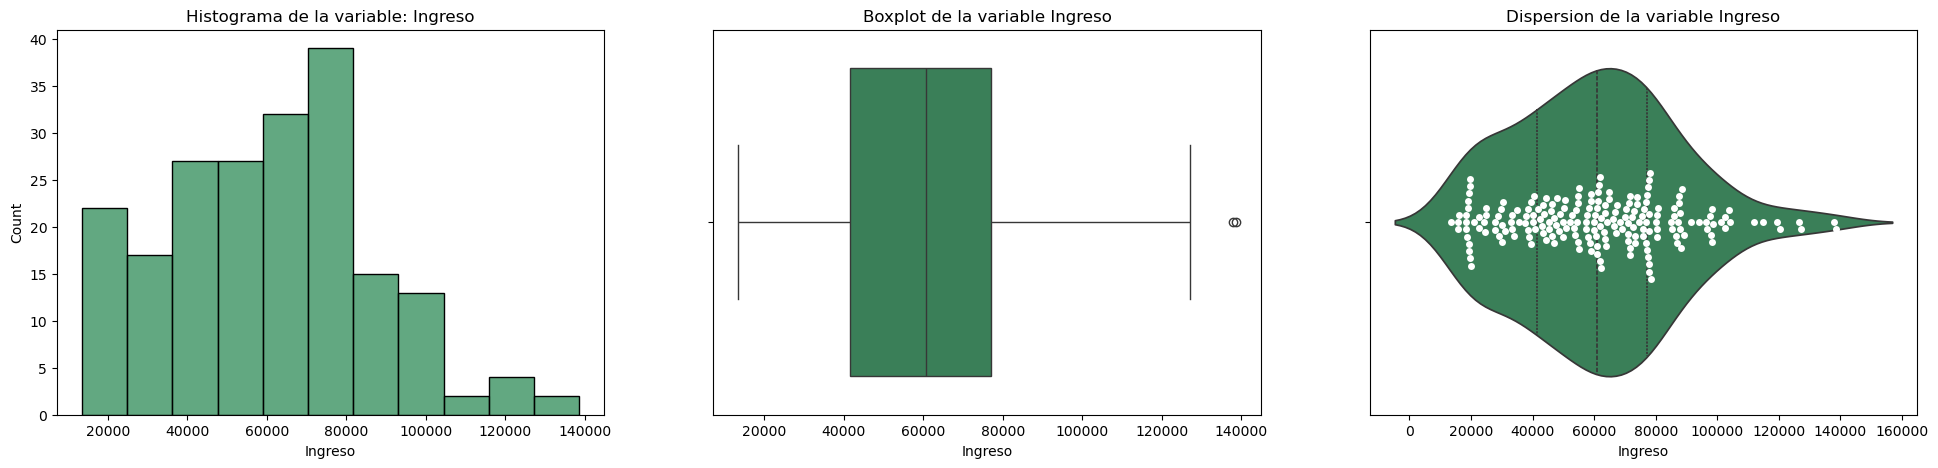

In [94]:
describe_variables(df_datos,variable="Ingreso")

Esta variable presenta una concentracion de datos en los valores bajos y medios como se ve en el diagrama de violin, con un valor promedio de aprox 60k, en este caso se ve que para los valores altos hay menor concentracion de clientes

##### Variable Puntaje Gasto

count  mean        std  min    25%   50%   75%   max
Puntaje_Gasto  200.0  50.2  25.823522  1.0  34.75  50.0  73.0  99.0

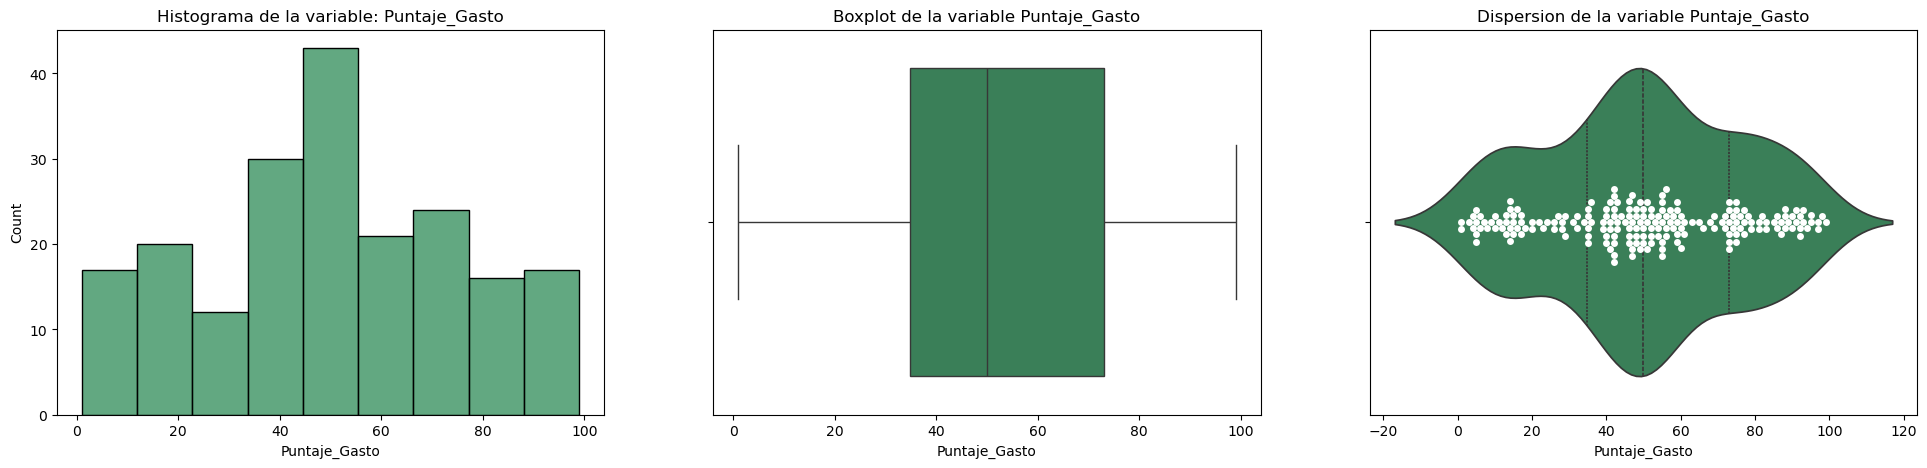

In [95]:
describe_variables(df_datos,variable="Puntaje_Gasto")

Esta variable cuenta con una media y mediana aprox de 50, lo cual nos indicaria una posible distribucion normal, sin embargo al ver le histograma y la grafica de violin se ve que no es el caso y que tambien presenta altas concentraciones de datos en los valores bajos y altos

##### Variable Genero

Genero  Id_Cliente   pct
0  Hombre          88  44.0
1   Mujer         112  56.0

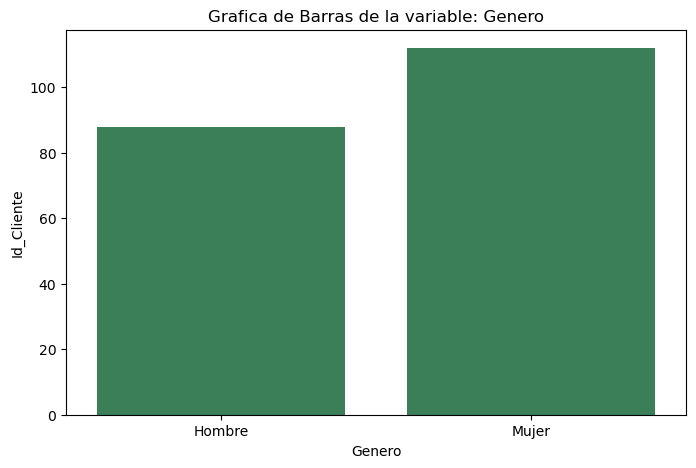

In [96]:
describe_variables_categ(df_datos, col="Genero")

Para esta variable se ve una mayor presencia de mujeres que de hombres

#### Relacion entre variables

##### Relacion entre variables: Inreso y Genero

Ingreso                                                               \
         count          mean           std       min         25%        50%   
Genero                                                                        
Hombre    88.0  62126.660455  26765.492953  13458.02  45003.0800  61706.565   
Mujer    112.0  59444.135714  25920.459216  15766.84  40013.4125  59355.305   

                               
               75%        max  
Genero                         
Hombre  77731.3025  138584.52  
Mujer   76788.3875  126685.78

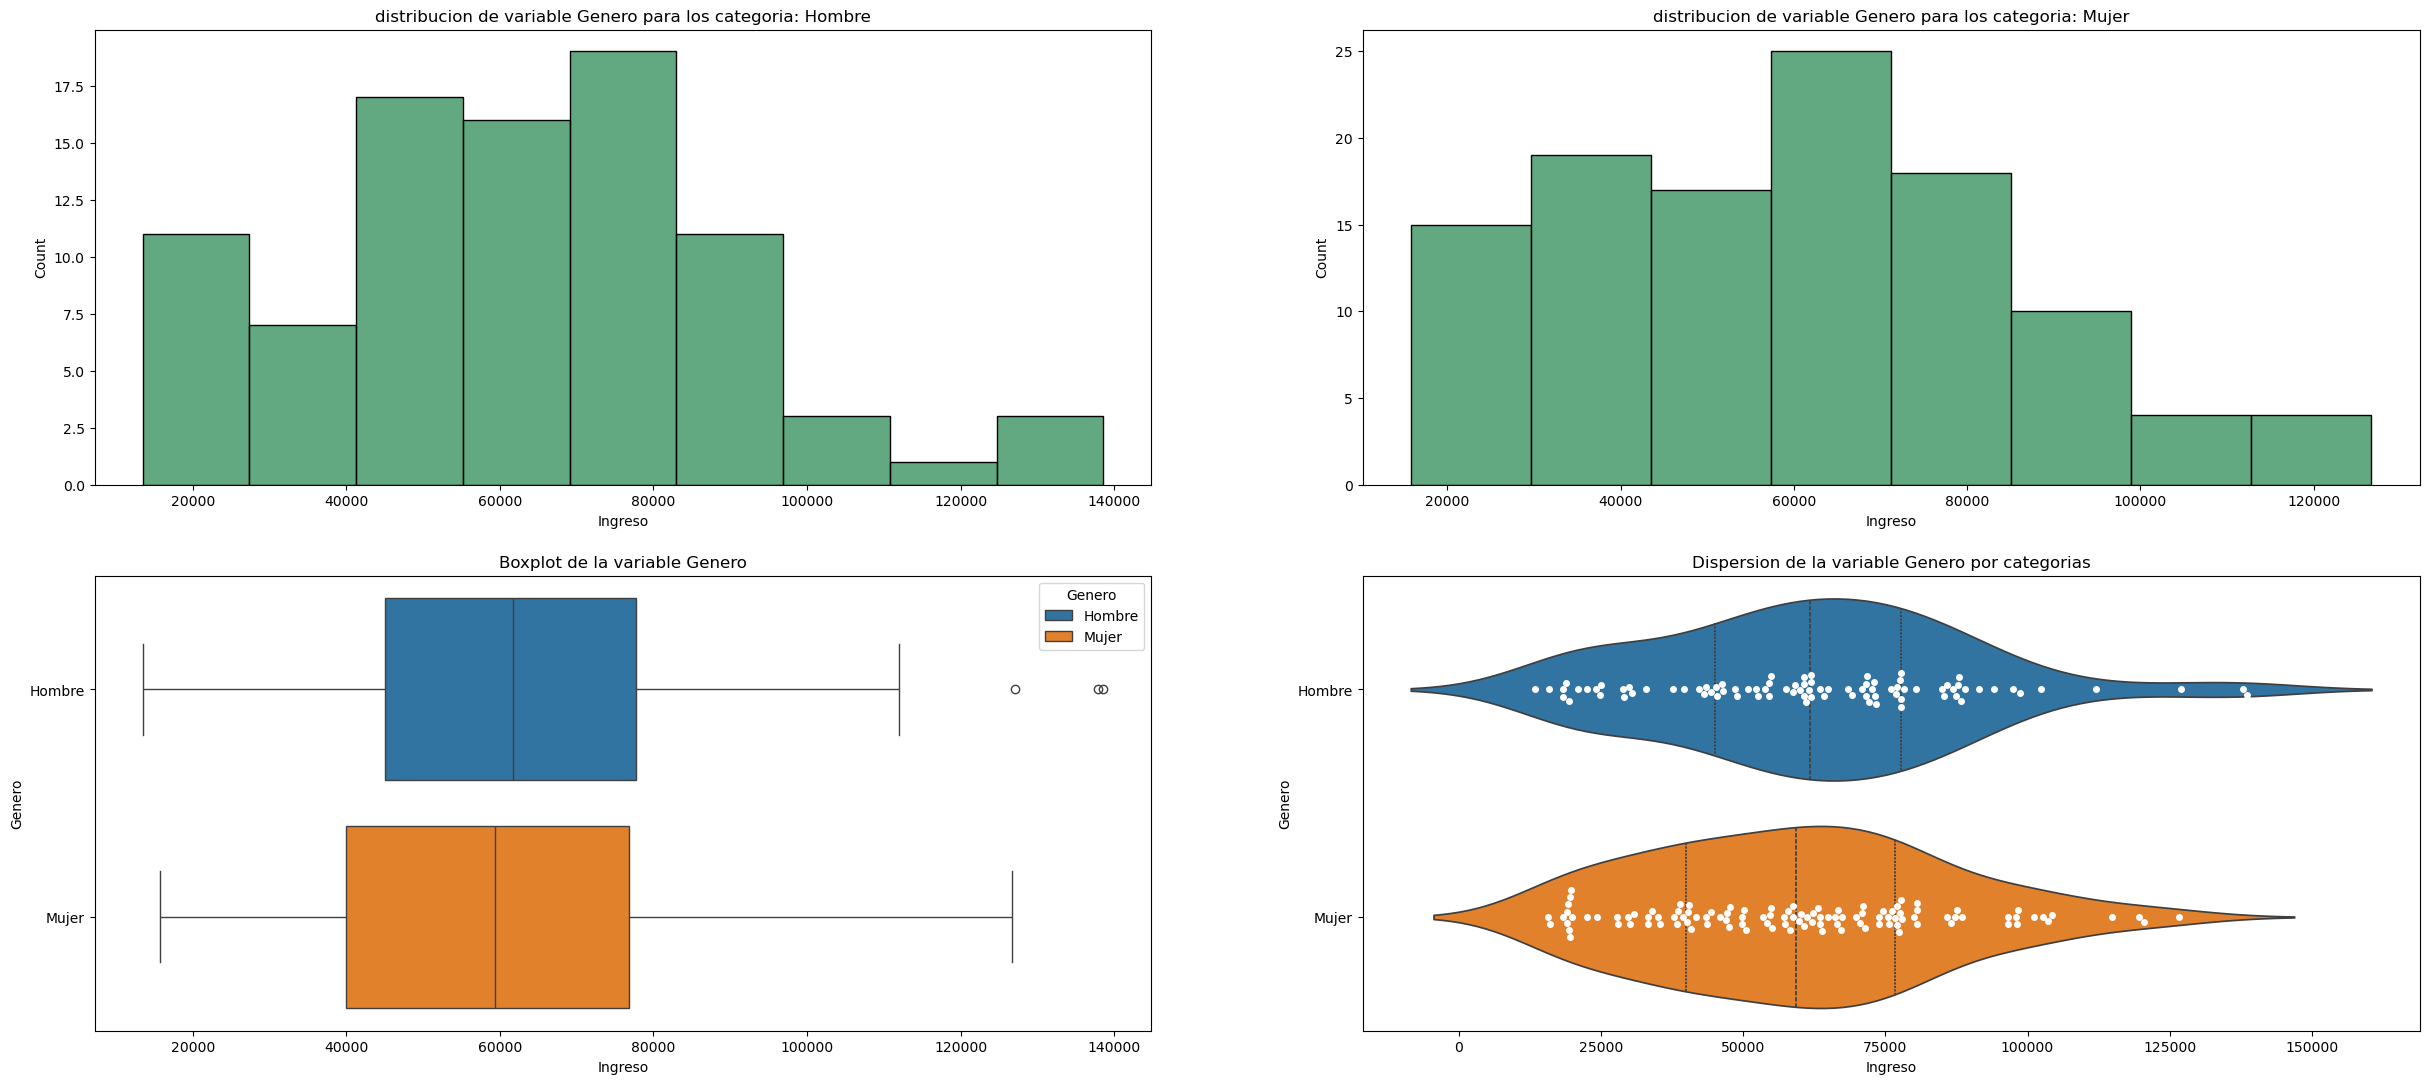

In [97]:
describe_variables(df_datos,"Ingreso",grupo="Genero")

al observar la relacion de estas dos variables se ve que hay una mayor concentracion de mujeres con ingresos bajos que de hombres, particularmente se evidencia al ver los valores del percentil 25 (45k en hombres vs 40k en mujeres). Luego de este punto la distribucion tiende a ser mas similar, lo cual se puede validar comparando los valores de los demas percentiles 

##### Relacion entre variables: Ingreso - Rango Edades

Ingreso                                                    \
               count          mean           std       min         25%   
rango_edades                                                             
1. 18-24        35.0  44454.795429  20378.208373  13458.02  24465.3200   
2. 25-34        54.0  71157.328148  27885.788157  19003.52  50141.6575   
3. 35-44        42.0  66957.096905  27722.049259  18797.16  50771.2225   
4. 45-54        39.0  58786.491026  24276.268114  24402.32  42447.5600   
5. 55-64        16.0  56357.093125  22351.828240  18434.74  46947.2075   
6. 65+          14.0  51420.789286  12686.437083  18437.21  45659.1800   

                                                
                    50%         75%        max  
rango_edades                                    
1. 18-24      46455.340  61564.3550   80360.65  
2. 25-34      75824.910  85872.9375  138584.52  
3. 35-44      71638.860  86762.7750  119534.68  
4. 45-54      55041.390  67337.0950  126685.78  
5. 55-64      54718.180  72384.2775   94049.49  
6. 65+        51546.645  61858.4675   64156.37

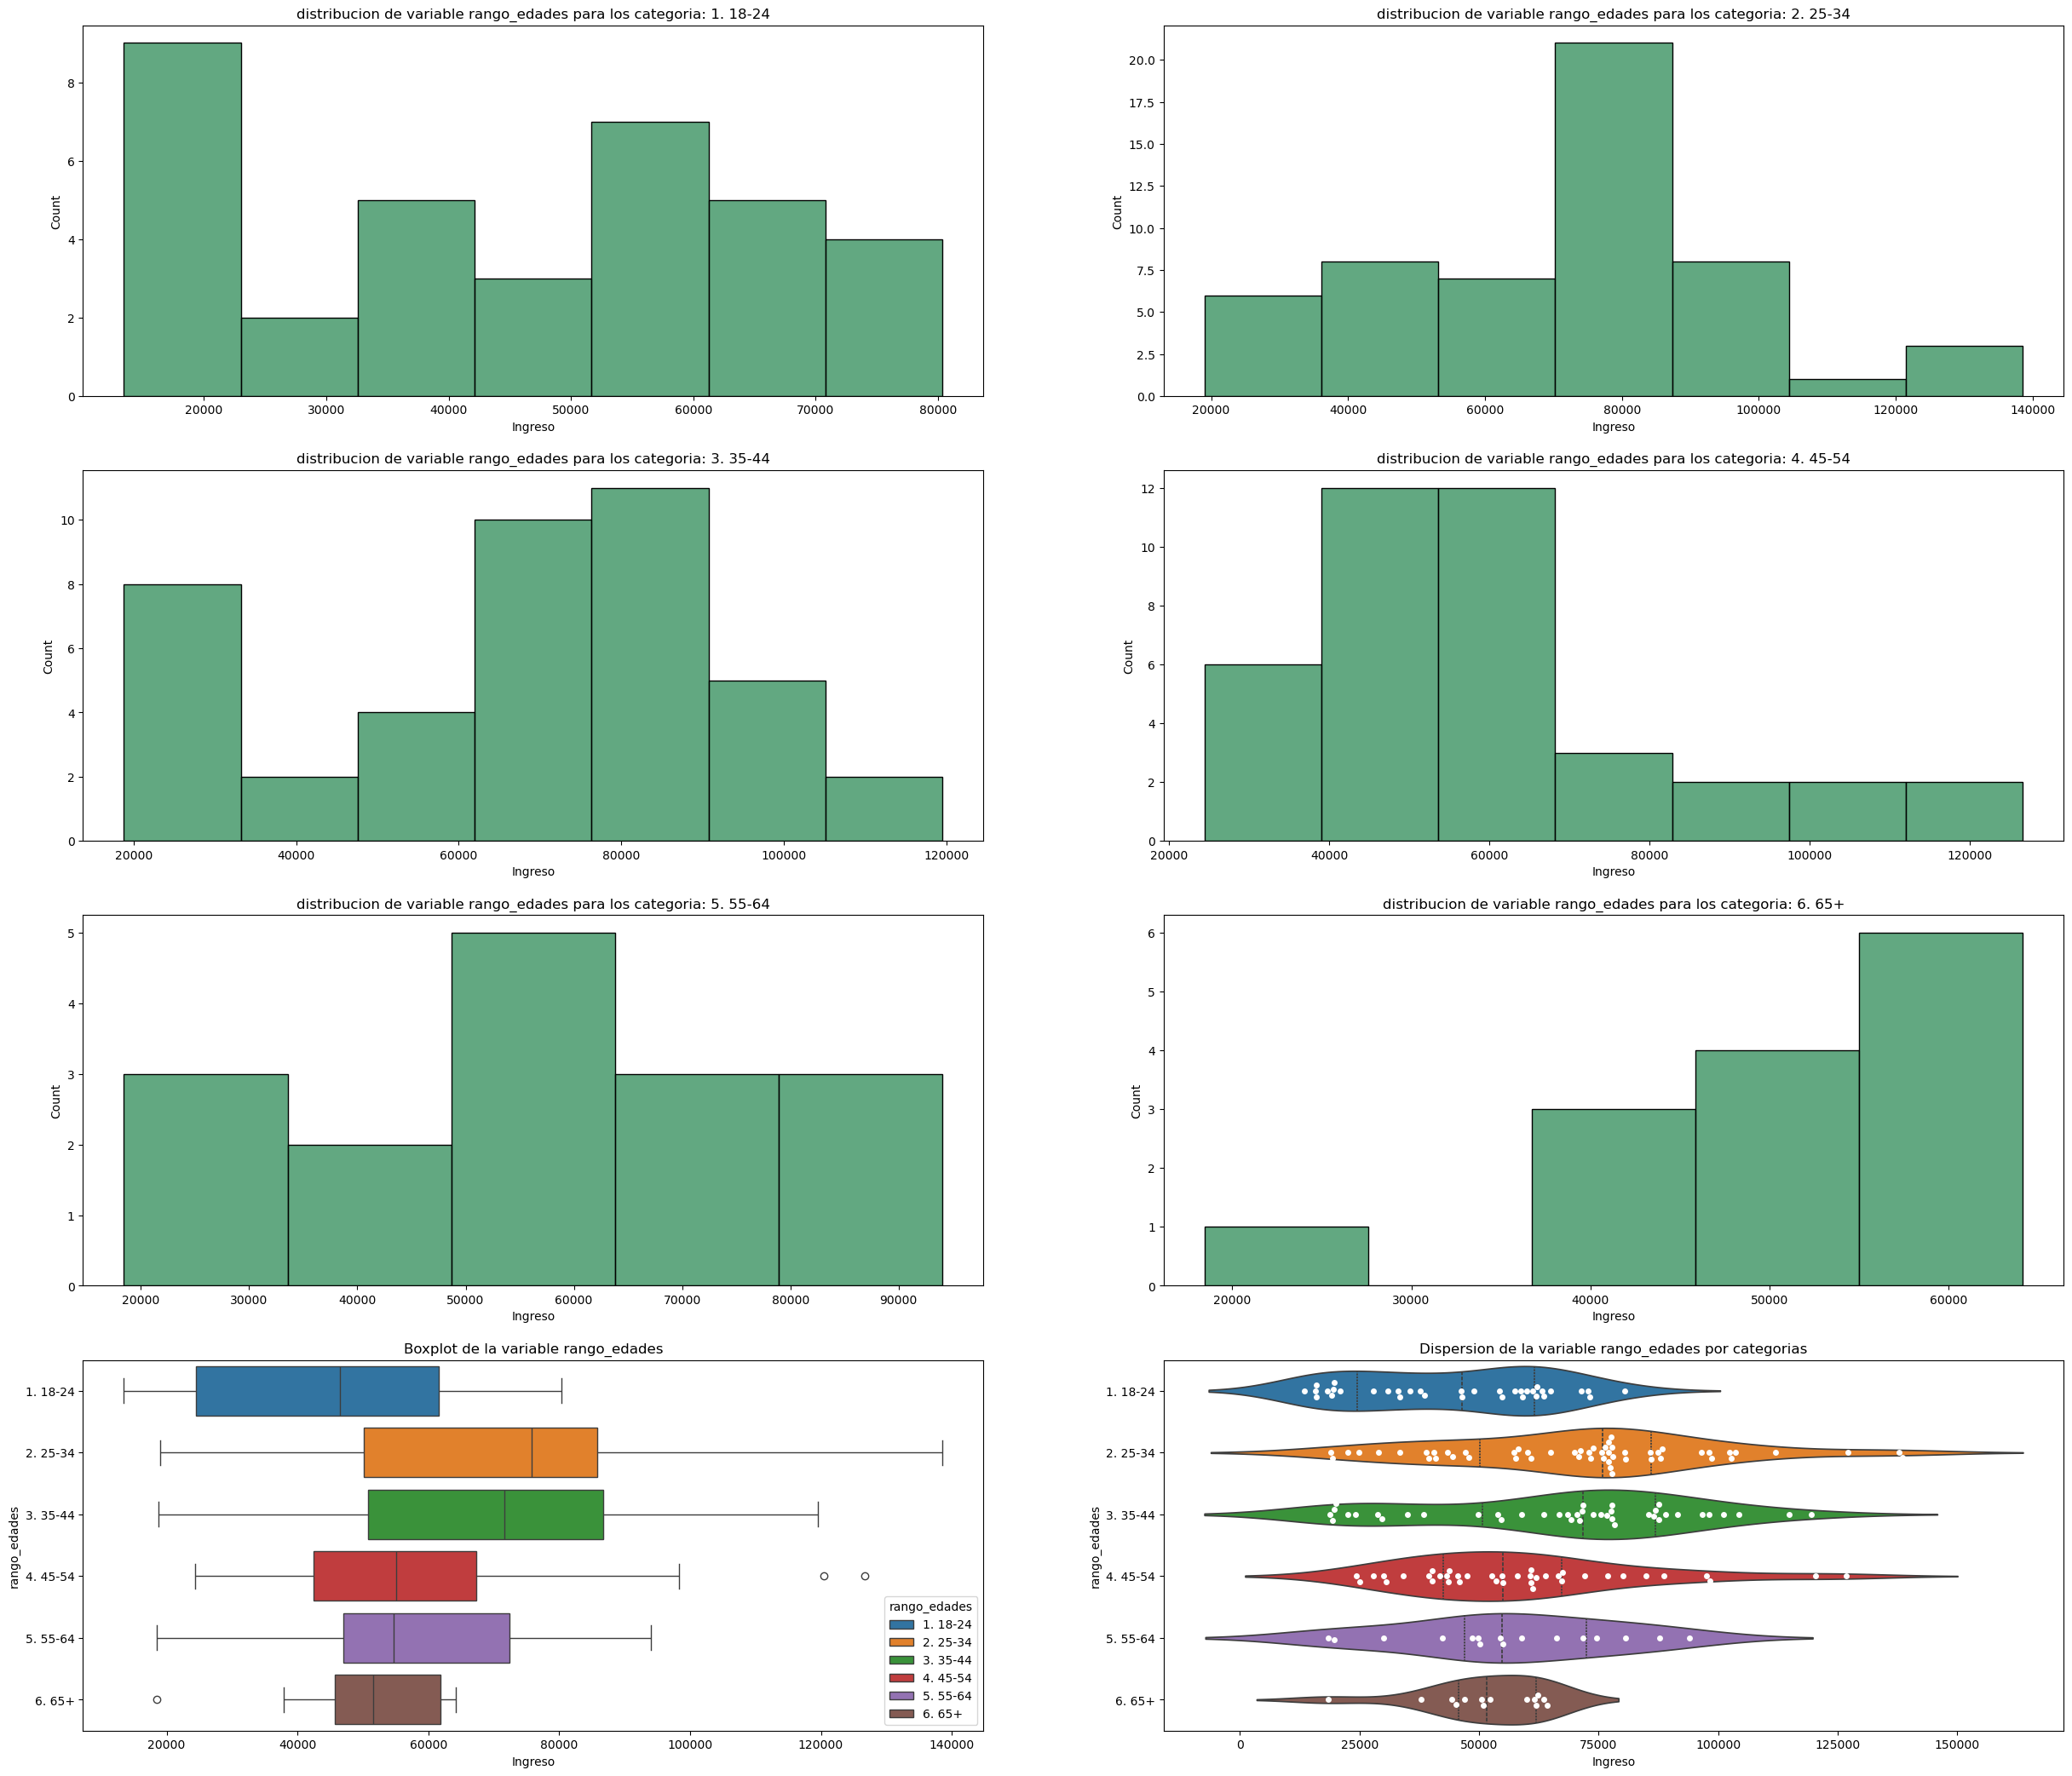

In [98]:
describe_variables(df_datos,"Ingreso",grupo="rango_edades")

En esta variable se ve mas marcada la diferencia de ingresos dependiendo de la edad, siendo las personas menores (18-24 años) las que en promedio tienen menor ingreso, luego siguen los 2 rangos de edad (25-34 años, 35-44 años) que en promedio tienen el ingreso mas alto, a partir de este punto los ingresos van disminuyendo.

Otro comportmamiento a notar qes que la dispersion de datos es mayor para los rangos de edad entre (25-34 años, 35-44 años) esto se valida mirando los valores de la desviacion estandar. Esto puede darse ya que estas son las edades en donde las personas son laboralmente activas, durante este periodo habra personas que incrementen sus ingresos mientras que otras permaneceran en los mismos rangos

##### Relacion entre variables: Puntaje Gasto y Genero

Puntaje_Gasto                                                  
               count       mean       std  min   25%   50%   75%   max
Genero                                                                
Hombre          88.0  48.511364  27.89677  1.0  24.5  50.0  70.0  97.0
Mujer          112.0  51.526786  24.11495  5.0  35.0  50.0  73.0  99.0

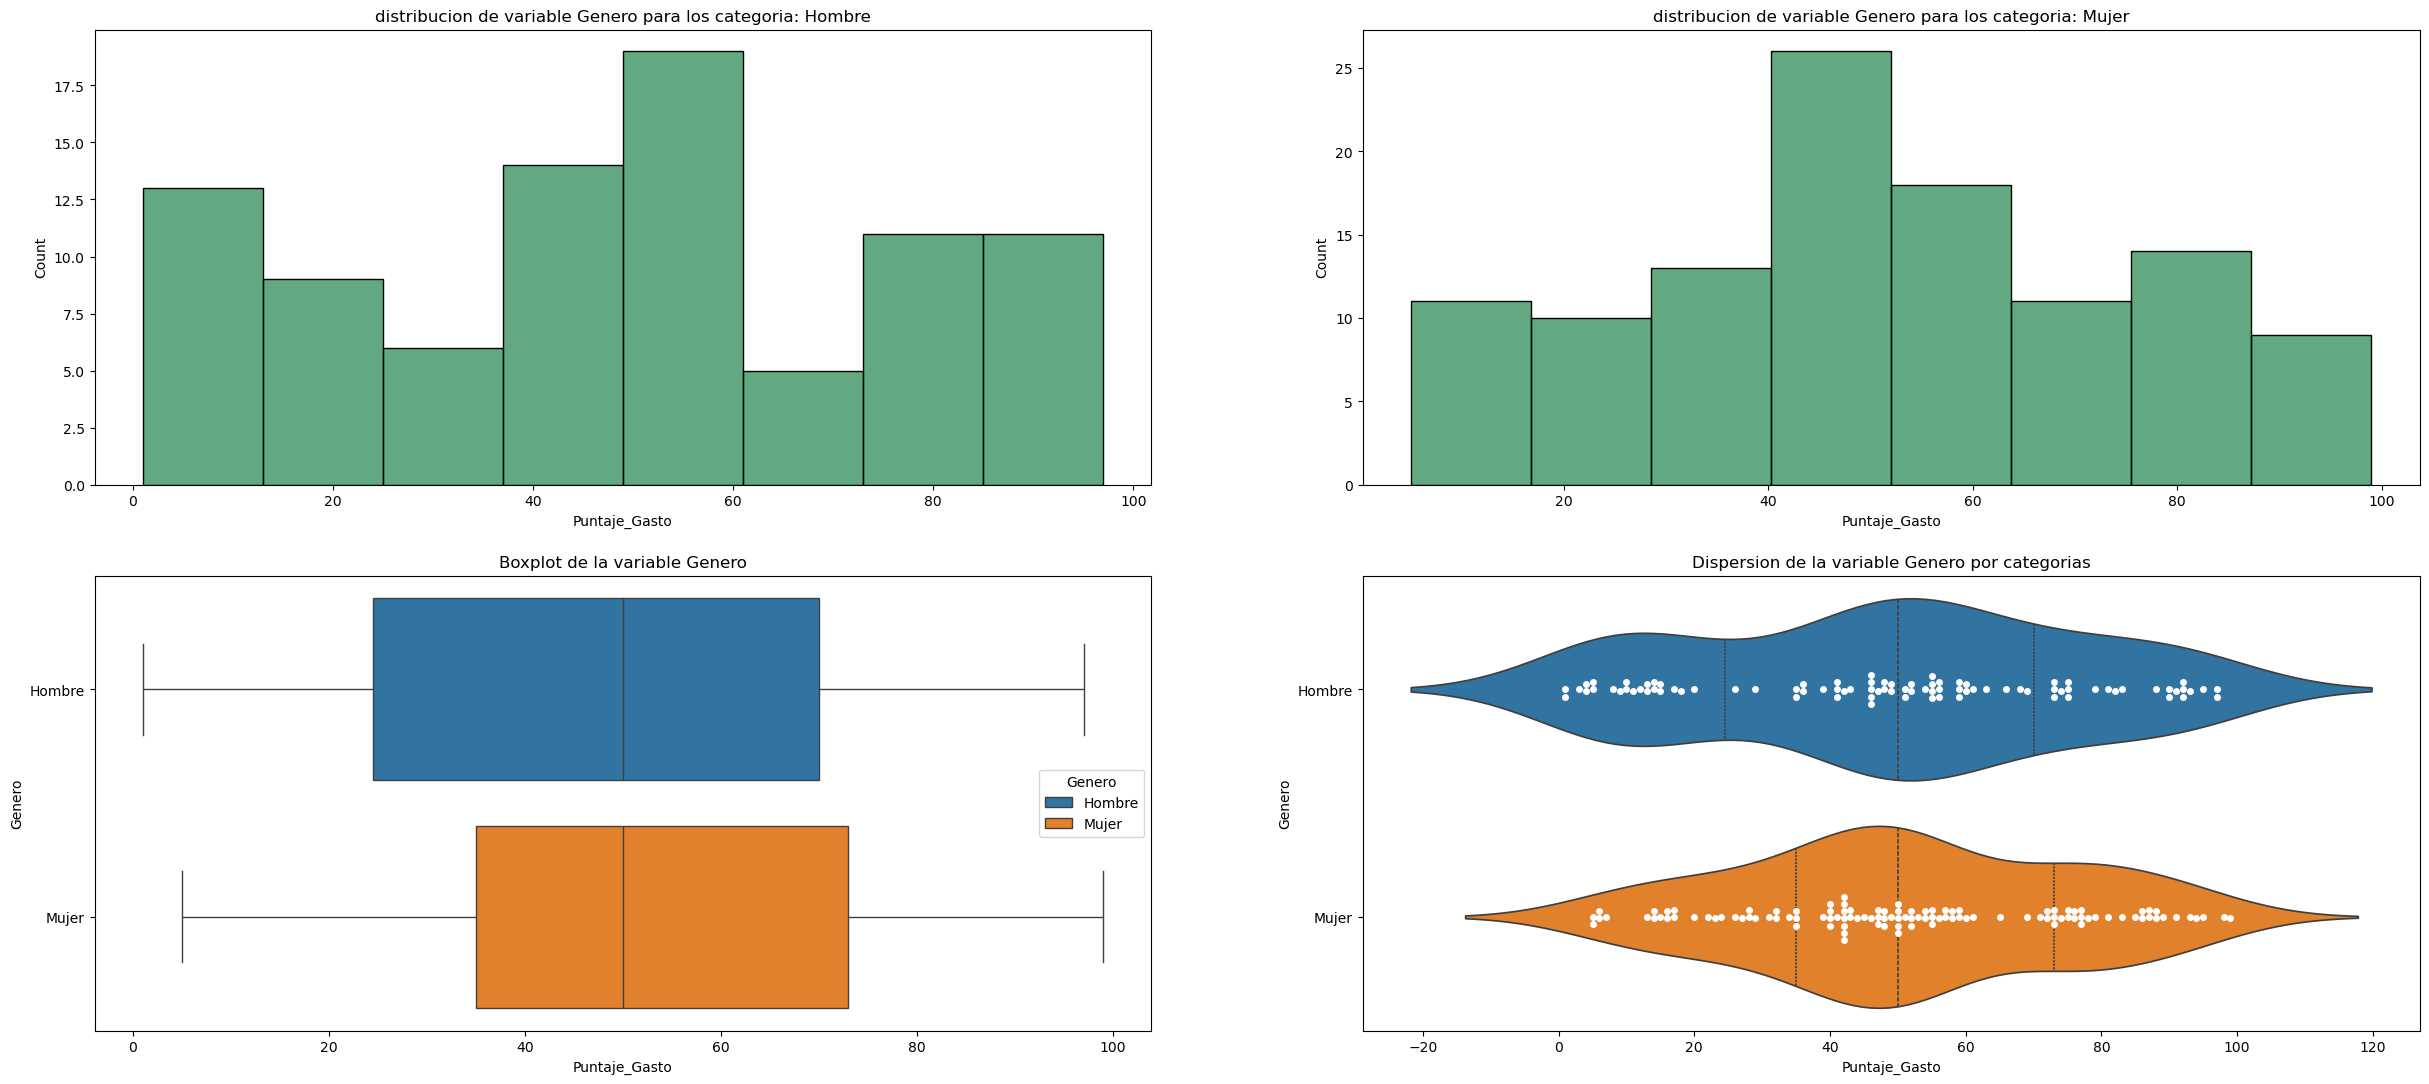

In [99]:
describe_variables(df_datos,"Puntaje_Gasto",grupo="Genero")

Al observar la diferencia en gastos por genero se ve que para este set de datos las mujeres tienden a gastar mas que los hombres, esto se evudencia en los diagramas de boxplot y al ver la comparacion de los percentiles 25 y 75, adicionalmente la desviacion estandar de los hombres es mayor que la de las mujeres indicando que los gastos realizados por los hombres comprenden un rango mayor que el gasto de las mujeres

##### Relacion entre variables: Puntaje Gasto y Rango Edades

Puntaje_Gasto                                                  \
                     count       mean        std   min    25%   50%    75%   
rango_edades                                                                 
1. 18-24              35.0  56.257143  24.659258   5.0  44.00  55.0  76.50   
2. 25-34              54.0  63.166667  24.283506   1.0  47.75  70.0  82.75   
3. 35-44              42.0  49.428571  30.700078   1.0  21.50  41.0  75.75   
4. 45-54              39.0  36.230769  16.261776   4.0  25.00  42.0  47.50   
5. 55-64              16.0  32.312500  21.752299   3.0  13.25  39.0  51.00   
6. 65+                14.0  46.714286  11.431593  14.0  43.75  49.0  54.25   

                    
               max  
rango_edades        
1. 18-24      94.0  
2. 25-34      97.0  
3. 35-44      99.0  
4. 45-54      59.0  
5. 55-64      60.0  
6. 65+        59.0

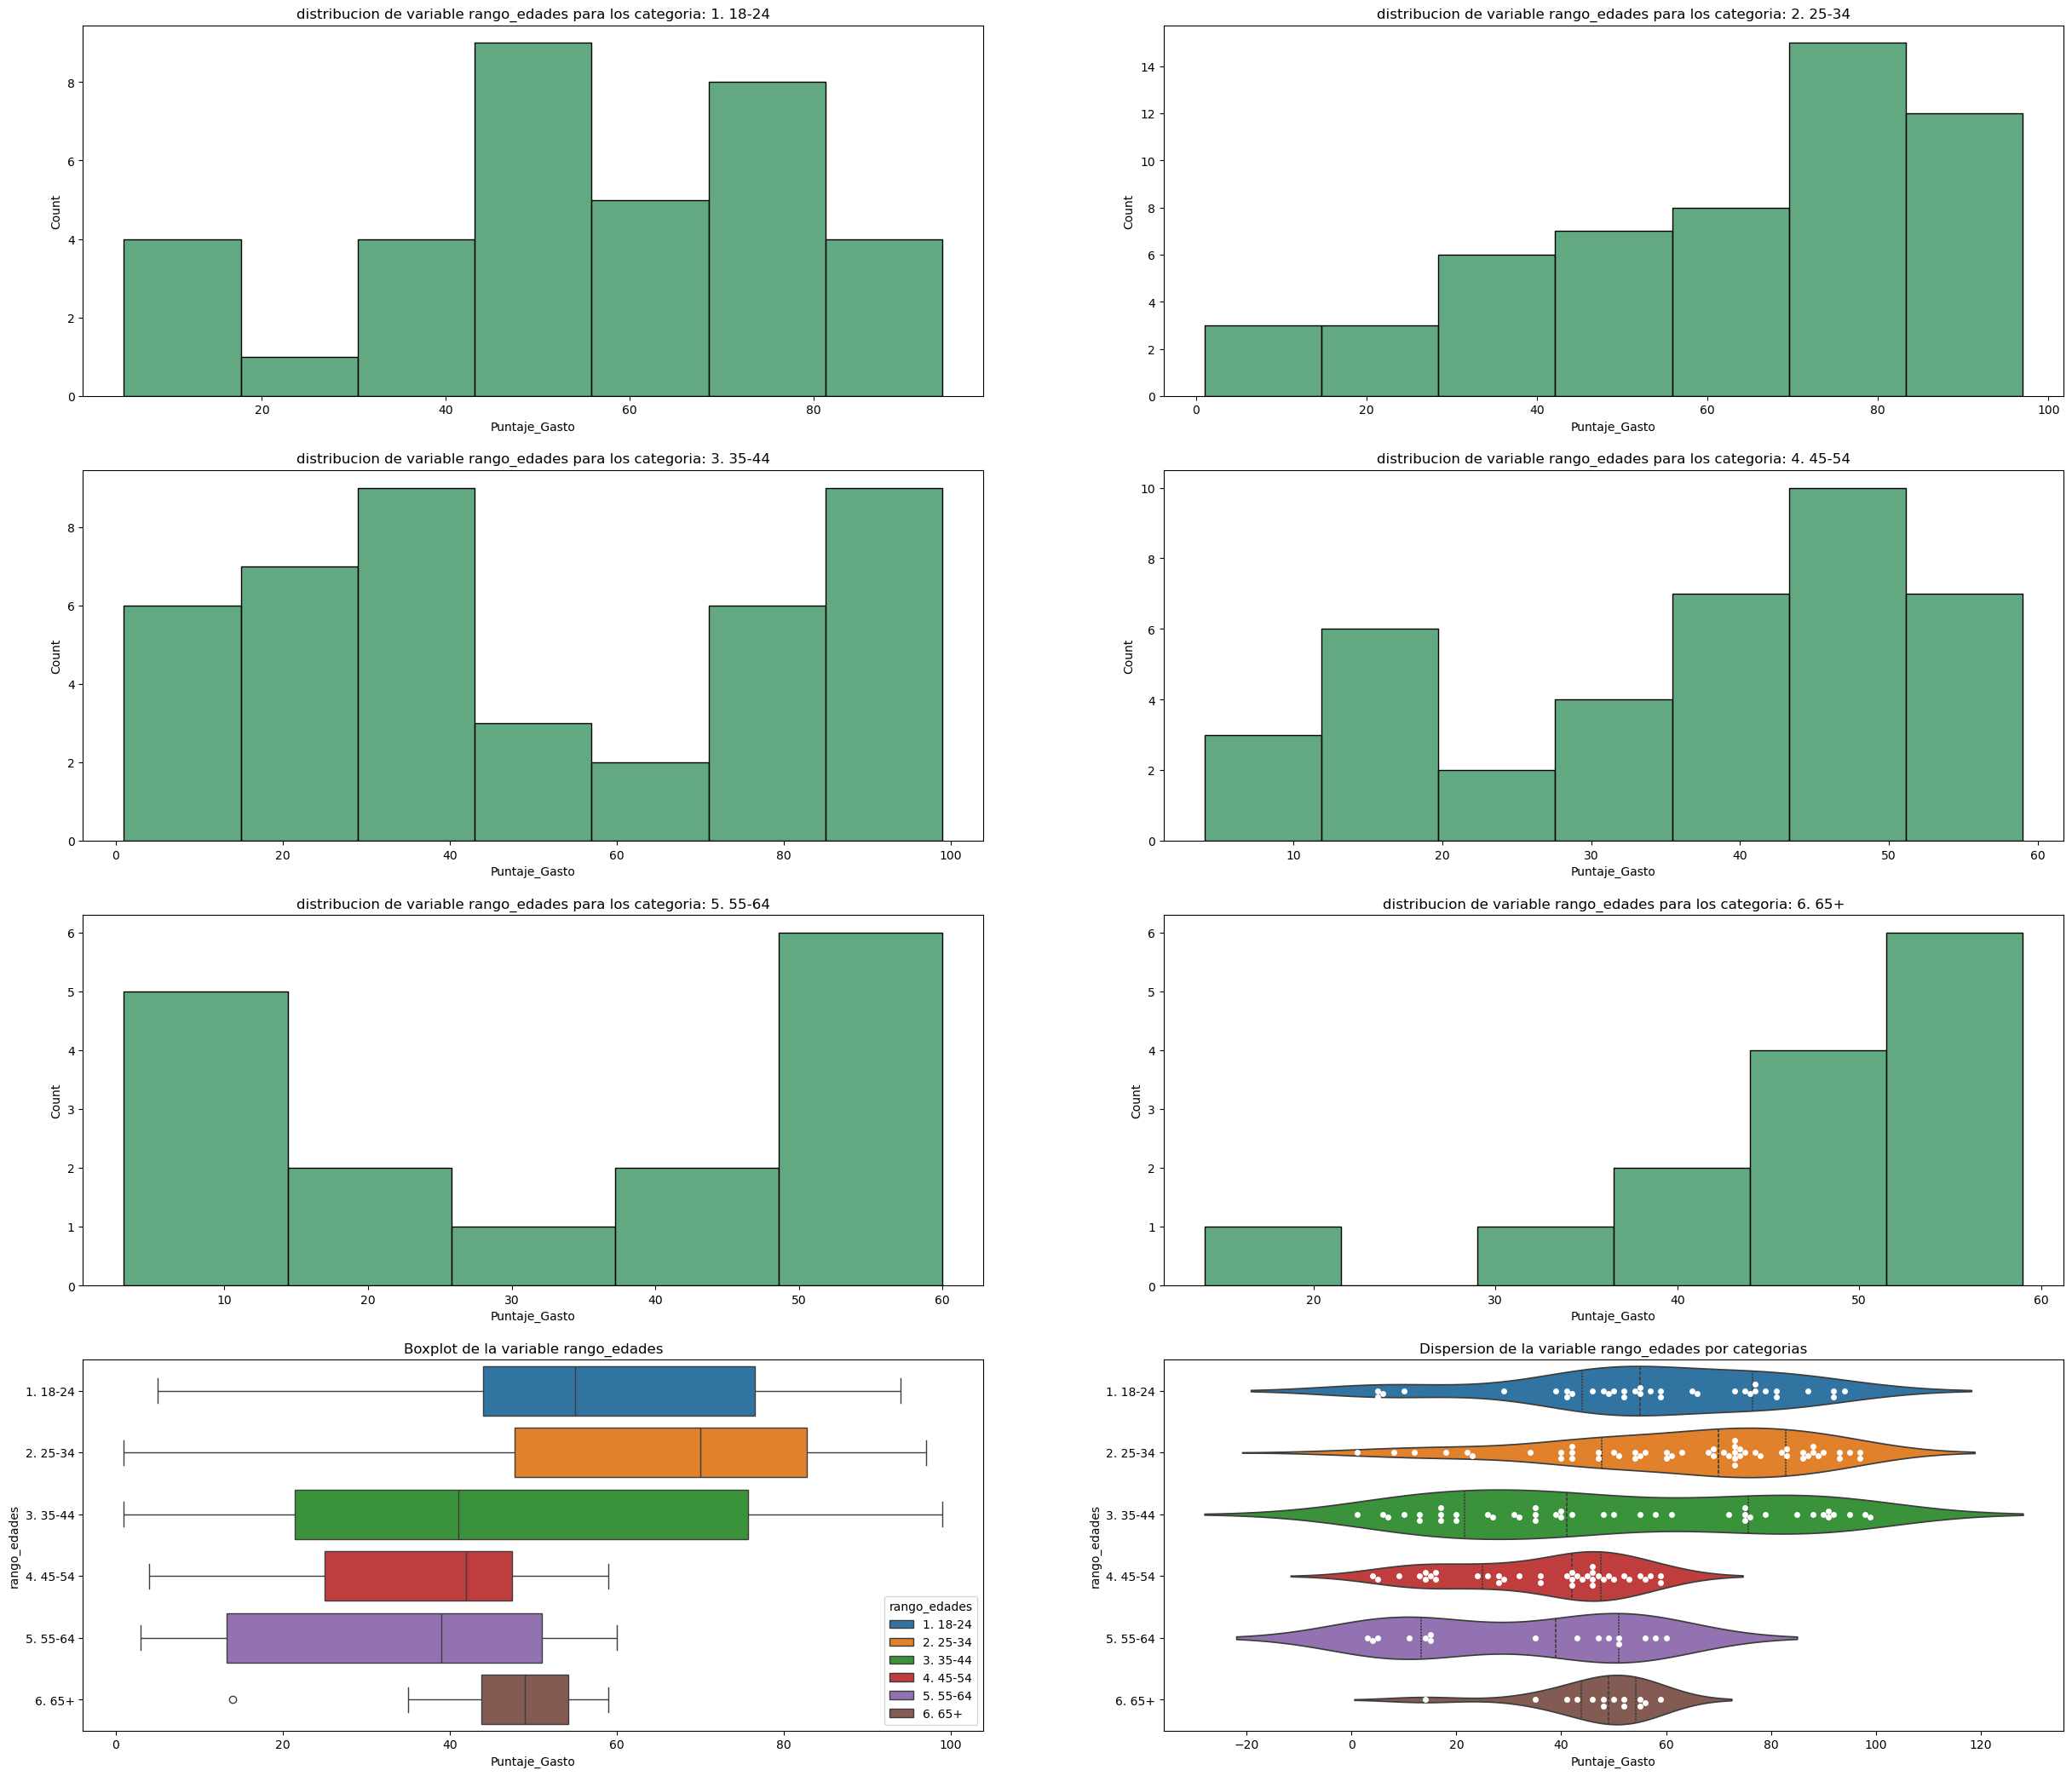

In [100]:
describe_variables(df_datos,"Puntaje_Gasto",grupo="rango_edades")

Nuevamente se ve una difrencia marcada en los gastos por rangos de edad, el gasto mas alto se da en los rangos de edad (18-24 ñoas, 25-34 años) esto se ve en los diagranas de boxplot, viendo que para estos rangos de edad el percentil 25 esta por encima del gasto promedio del resto de edades, quizas esto se debe a una vida mas activa en estos rangos de edad u otras necesidades de cada persona. 

Para el rango de edad de 35-44 años, se tiene la mas alta desviacion estandar, por lo que para este rango de edad el puntaje de datos tiene un rango mas alto, este comportamiento puede estar dado por las distintas caracteristicas/necesidades de cada individuo, por ejemplo algunos de estos tendarn hijos lo cual puede aumentar la necesidad de gastar en la tienda.

##### Relacion entre variables: Rango Edades y Genero

a continuacion se verá como influye la relacion de genero con el rango de edad en las variables de Ingreso y Puntaje Gasto

In [101]:
# Creacion de nueva variable categorica que asocia el rango de edad con el genero
df_datos["edades_genero"] = df_datos["rango_edades"] + "-" + df_datos["Genero"]

##### Relacion entre variables: Rango Edades, Genero e Ingresos

Ingreso                                                    \
                  count          mean           std       min         25%   
edades_genero                                                               
1. 18-24-Hombre    16.0  46748.482500  21515.089905  13458.02  29984.6525   
1. 18-24-Mujer     19.0  42523.269474  19749.373173  15766.84  23830.8250   
2. 25-34-Hombre    22.0  78927.434545  32734.446993  22531.85  61793.4150   
2. 25-34-Mujer     32.0  65815.380000  23049.652497  19003.52  46428.2325   
3. 35-44-Hombre    18.0  67001.986111  22499.533107  18797.16  58063.7100   
3. 35-44-Mujer     24.0  66923.430000  31556.048353  19281.75  37553.3550   
4. 45-54-Hombre    14.0  58029.127143  20522.769162  24993.78  43724.2375   
4. 45-54-Mujer     25.0  59210.614800  26541.550152  24402.32  41739.8400   
5. 55-64-Hombre     9.0  55780.227778  25094.510046  18434.74  42262.0400   
5. 55-64-Mujer      7.0  57098.777143  20204.546850  19617.67  49946.0550   
6. 65+-Hombre       9.0  51366.806667  14577.260971  18437.21  45222.0600   
6. 65+-Mujer        5.0  51517.958000   9902.628197  37926.15  46970.5400   

                                                   
                       50%         75%        max  
edades_genero                                      
1. 18-24-Hombre  47652.490  60447.4525   80360.65  
1. 18-24-Mujer   38599.280  61699.1550   71427.64  
2. 25-34-Hombre  77390.985  96065.5225  138584.52  
2. 25-34-Mujer   72515.755  78621.0625  103654.79  
3. 35-44-Hombre  71638.860  83590.7100   91426.18  
3. 35-44-Mujer   72184.815  89797.3150  119534.68  
4. 45-54-Hombre  60761.560  69593.5850   97525.80  
4. 45-54-Mujer   54827.740  67219.4800  126685.78  
5. 55-64-Hombre  54475.760  71651.0800   94049.49  
5. 55-64-Mujer   58838.530  70389.0600   80565.01  
6. 65+-Hombre    52200.840  61969.1500   64156.37  
6. 65+-Mujer     50529.760  59872.0800   62291.26

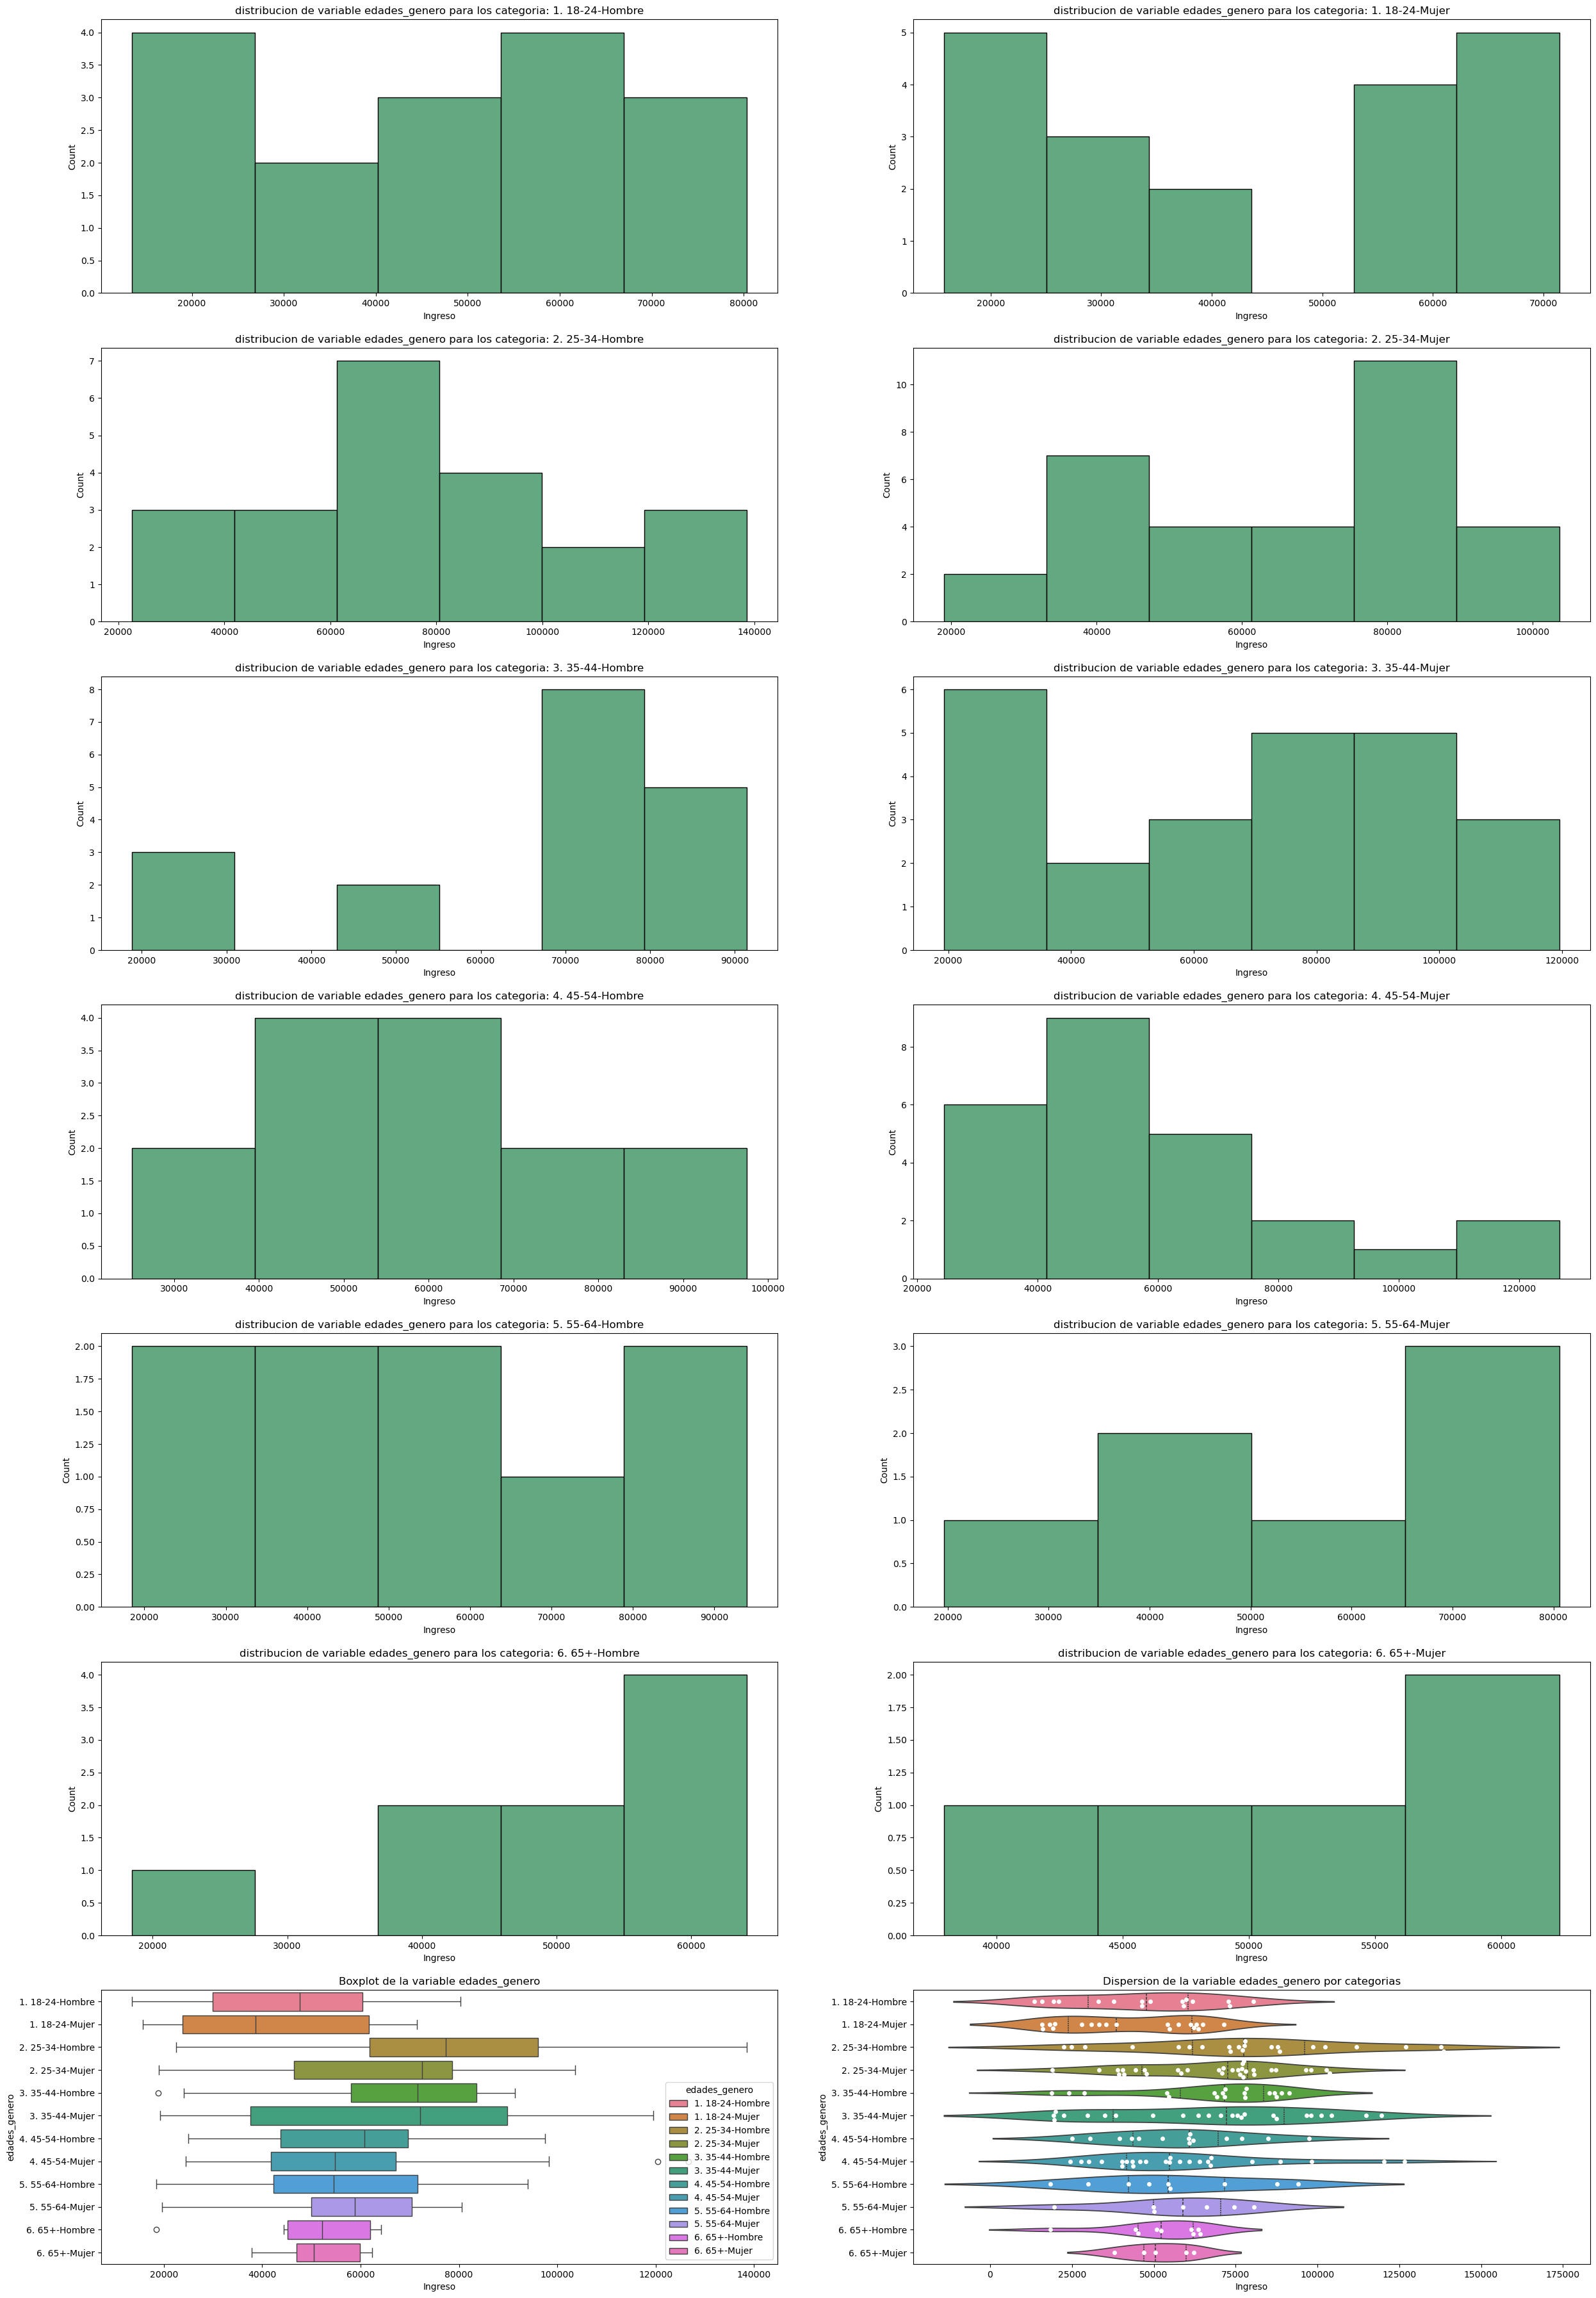

In [102]:
describe_variables(df_datos,variable="Ingreso", grupo="edades_genero")

Al desglosar las variables en estas nuevas categorias de genero con edad, se ve que las conclusion incial en donde las mujeres tienden a tener un gasto mas alto no es verdad para todos los rangos de edad, en alguos casos se presenta el caso inverso. Esto nos muestra que para capturar o describir de mejor manera el comportamiento de los clientes seria necesario tener en cuenta estas dos variables al mismo tiempo ya que la nueva dimension permite extraer informacion valiosa para cada grupo formado 

##### Relacion entre variables: Rango Edades, Genero y Puntaje Gasto

Puntaje_Gasto                                                  \
                        count       mean        std   min    25%   50%    75%   
edades_genero                                                                   
1. 18-24-Hombre          16.0  51.875000  27.796583   5.0  40.50  53.5  69.25   
1. 18-24-Mujer           19.0  59.947368  21.754881   6.0  49.00  57.0  76.50   
2. 25-34-Hombre          22.0  62.454545  28.468407   1.0  55.25  71.0  80.25   
2. 25-34-Mujer           32.0  63.656250  21.413908  22.0  45.75  70.0  83.75   
3. 35-44-Hombre          18.0  50.777778  33.502512   1.0  17.75  51.5  84.75   
3. 35-44-Mujer           24.0  48.416667  29.120315   6.0  26.75  40.0  75.25   
4. 45-54-Hombre          14.0  34.357143  15.775381   4.0  26.75  38.5  46.00   
4. 45-54-Mujer           25.0  37.280000  16.754402   5.0  24.00  43.0  50.00   
5. 55-64-Hombre           9.0  28.444444  23.173860   3.0  11.00  15.0  51.00   
5. 55-64-Mujer            7.0  37.285714  20.385569   5.0  25.00  43.0  52.50   
6. 65+-Hombre             9.0  46.000000  13.453624  14.0  43.00  48.0  55.00   
6. 65+-Mujer              5.0  48.000000   7.713624  35.0  48.00  50.0  52.00   

                       
                  max  
edades_genero          
1. 18-24-Hombre  92.0  
1. 18-24-Mujer   94.0  
2. 25-34-Hombre  97.0  
2. 25-34-Mujer   95.0  
3. 35-44-Hombre  95.0  
3. 35-44-Mujer   99.0  
4. 45-54-Hombre  56.0  
4. 45-54-Mujer   59.0  
5. 55-64-Hombre  60.0  
5. 55-64-Mujer   58.0  
6. 65+-Hombre    59.0  
6. 65+-Mujer     55.0

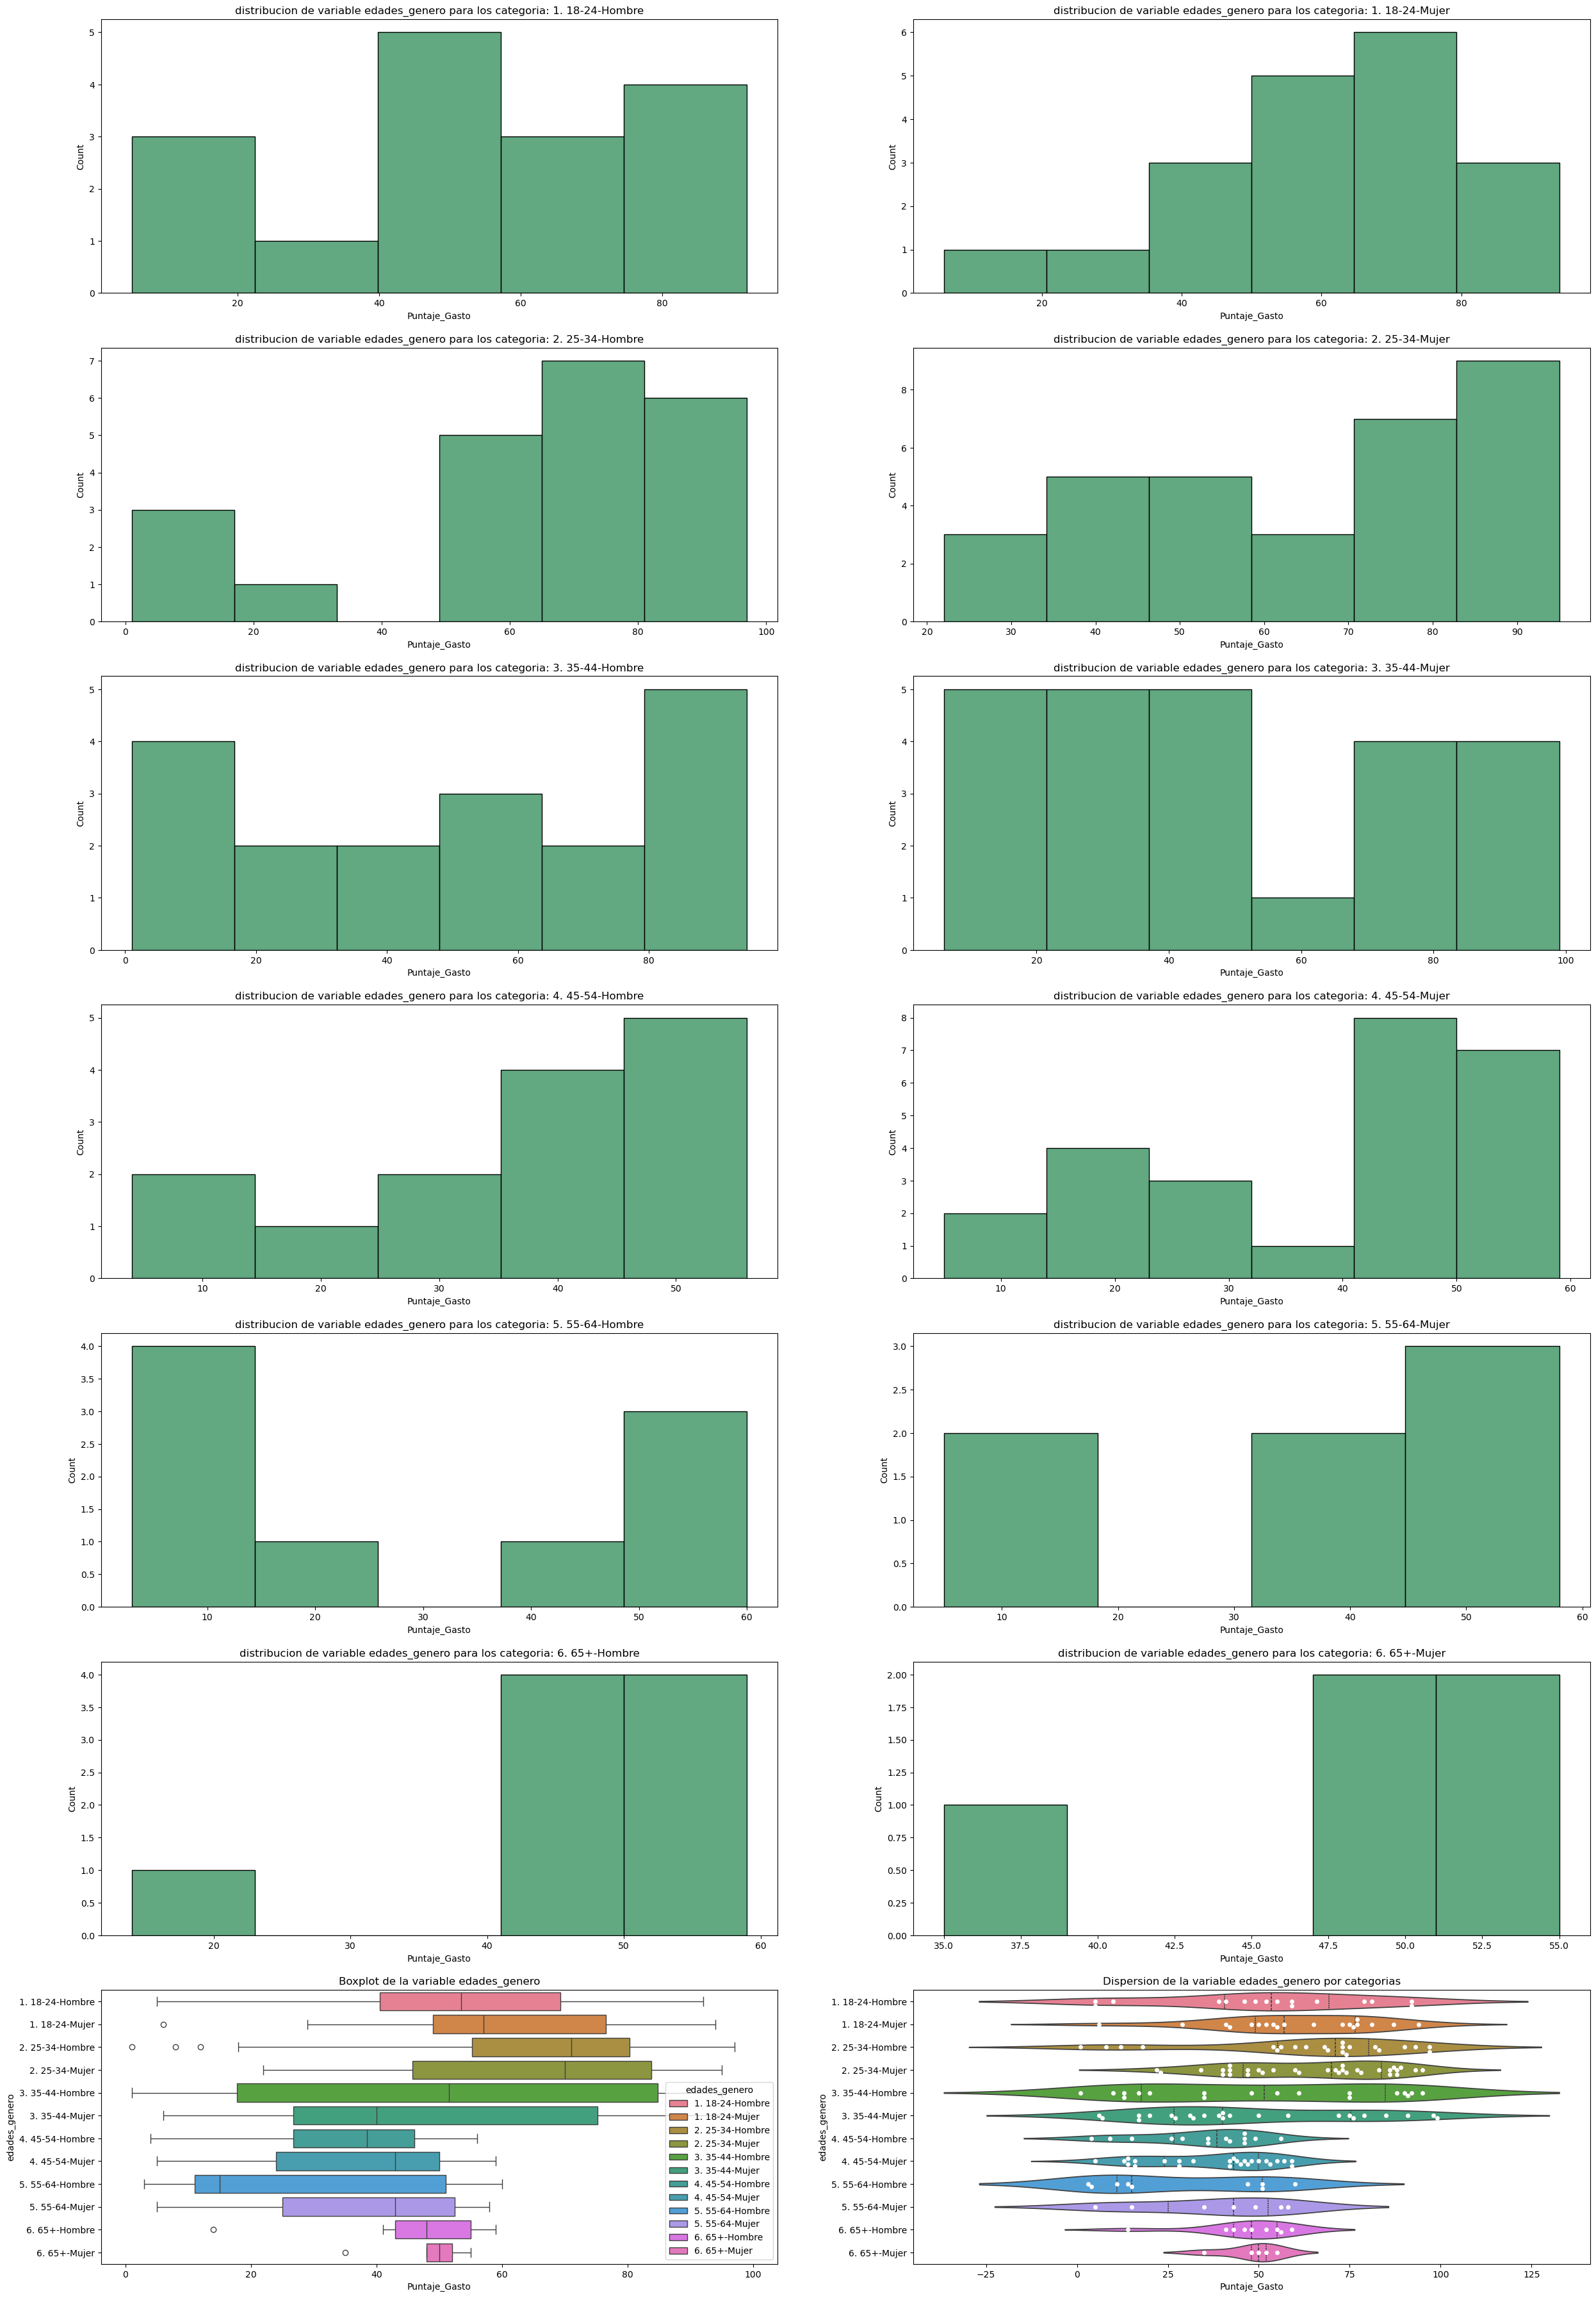

In [103]:
describe_variables(df_datos,"Puntaje_Gasto",grupo="edades_genero")

En estas variables el comportamiento de gasto se mantiene similar entre hombres y mujeres para las edades menores a 34 años, sin embargo para edades mas altas se ve una clara diferencia en los gastos promedio de los hombres y las mujeres, por ejemplo el rango de 35-44 y 55-64 (el mas alto). Asi como en el analisis anterior se ve que relacionar estas dos variables permite tener un mejor entendimiento de gurpos particulares, que estan por fuera del comportamiento incialmente identificado anteriormente.

##### Dispecion de puntos observando la relacion de ingresos y gastos

A continuacion se realizan distintas graficas de dispersion de puntos, en donde el eje **X** es el ingreso y el eje **Y** es el puntaje del gasto, esto con el fin de ver el comportamiento de los datos. Luego se mostrara la misma gráfica solo que añadiendo un color para las categorias de las variables (Genero, Rango Ingreso y la combinacion de estas dos), esto con el fin de identificar si existen grupos formados de forma natural.

Text(0.5, 1.0, 'dispercion de datos con combinacion de genero y rango edad')

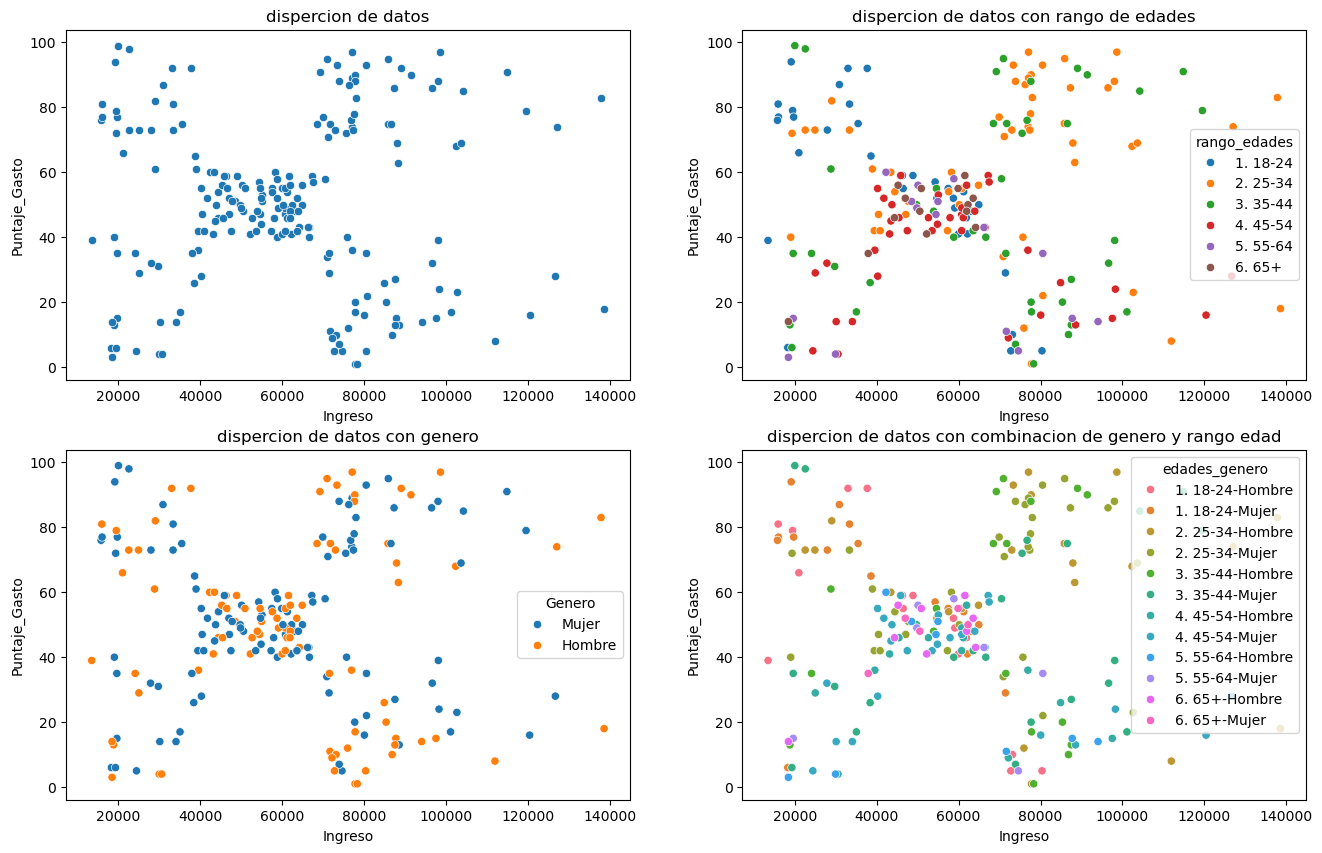

In [104]:
n_rows = 2
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*8, n_rows*5))
axs = ax.flatten()

sns.scatterplot(data=df_datos, x="Ingreso",y="Puntaje_Gasto",ax=axs[0])
axs[0].set_title("dispercion de datos")
sns.scatterplot(data=df_datos.sort_values(by="rango_edades"), x="Ingreso",y="Puntaje_Gasto",hue="rango_edades",ax=axs[1])
axs[1].set_title("dispercion de datos con rango de edades")
sns.scatterplot(data=df_datos, x="Ingreso",y="Puntaje_Gasto",hue="Genero",ax=axs[2])
axs[2].set_title("dispercion de datos con genero")
sns.scatterplot(data=df_datos.sort_values("edades_genero"), x="Ingreso",y="Puntaje_Gasto",hue="edades_genero",ax=axs[3])
axs[3].set_title("dispercion de datos con combinacion de genero y rango edad")

en las graficas anteriores se observan lo que pueden ser 5 grupos, hay una concentracion de puntos en cada cuadrante y adicional hay otra en el centro de la gráfica. A cada uno de estos grupos se le podria asignar unas caracteristicas:

| Grupo                   | Número | Descripción                                      |
|-------------------------|--------|--------------------------------------------------|
| Central                 | 4      | Personas con ingresos promedio y con un gasto promedio |
| Superior derecho        | 2      | Personas con un alto ingreso y alto gasto         |
| Superior izquierdo      | 3      | Personas con un alto gasto e ingresos bajos       |
| Inferior derecho        | 0      | Personas con alto ingreso y bajo gasto            |
| Inferior izquierdo      | 1      | Personas con bajo ingreso y bajo gasto            |

Cuando se observa como esta localizado el genero en la grafica de dispersion a simple vista no se ve una relación entre el genero y alguno de los cuadrantes identificados antes. Sin embargo para la variable de rango edad se ven unos patrones. En los cuadrantes superiores (alto gasto) se ve una concentracio mas alta de los rangos de edad 18-24, 25-34, 35-44, esto quiere decir que en esta tienda estos rangos de edad son los que realizan un mayor gasto. La diferencia entre los rangos de edad radica en los ingresos que tiene cada rango, en el caso de 18-24 la mayoria se encuentra en ingreso bajo, mientras que los de 35-44 estan en un ingreso alto. El rango de 25-34 se encuentra en ambos rangos de ingreso con una mayor tendencia a estan en los valores altos.

### 3. Clustering Jerárquico

#### 3.1. Dendrogramas

Agrupe a los clientes utilizando sólo dos variables: su ingreso y el puntaje de gastos. Para ello retenga estas dos variables, estandarízelas, construya y grafique un dendograma. Para la construcción del dendrograma utilice el enlace 'ward' y la distancia euclidiana. Explique la importancia de estandarizar los datos.

In [105]:
# Escalado de datos
scaler = StandardScaler()
df_datos_scaled = pd.DataFrame(scaler.fit_transform(df_datos[["Ingreso","Puntaje_Gasto"]]))

# Validacion del resultado
df_datos_scaled.describe()

0             1
count  2.000000e+02  2.000000e+02
mean  -1.243450e-16 -1.021405e-16
std    1.002509e+00  1.002509e+00
min   -1.800440e+00 -1.910021e+00
25%   -7.295316e-01 -5.997931e-01
50%    5.859924e-03 -7.764312e-03
75%    6.305804e-01  8.851316e-01
max    2.975897e+00  1.894492e+00

Los datos se escalan para que la magnitud de los mismos no tenga influencia en las distancias calculadas por los distintos métodos de clusterizacion que serán aplicados. Ya que si una variable esta en el rango de millones y otra en el rango de centenas, las diferencias entre los valores de una variable se veran "opacadas" por la magnitud de la otra variable

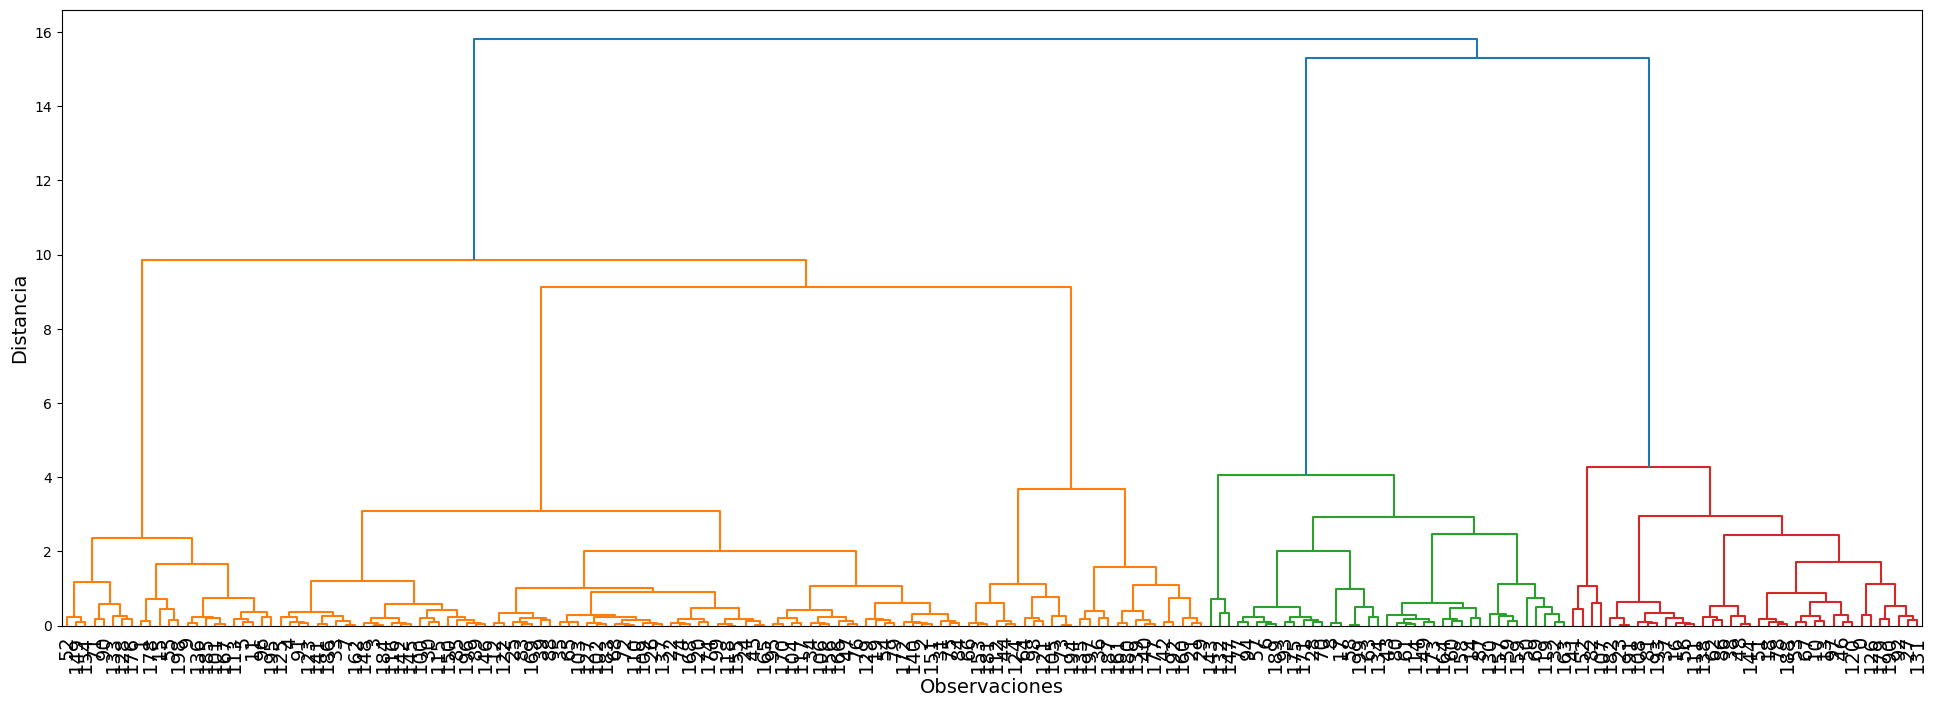

In [106]:
# calculo de distancias entre los datos
dist = pdist(df_datos_scaled, metric='euclidean')
Z = linkage(dist, method='ward')

# Graficar el dendograma
fig, ax = plt.subplots(figsize=(24, 8))
d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax)
ax.set_xlabel('Observaciones', fontsize=14)
ax.set_ylabel('Distancia', fontsize=14)
plt.show()

Luego de estandarizar los datos, se calculan las distancias entre todos los puntos por medio de la distancia euclidiana

$$
d_{ii'} = d(x_i, x_{i'}) = \sqrt{(x_i - x_{i'})^2}
$$

luego se realiza la asociacion entre puntos para encontrar clusters aplicando el criterio de **ward** el cual busca minimizar la varianza intra cluster con cada nueva union de puntos a un cluster.

El resultado de cada una de estas asociaciones se muestra en el dendograma anterior

#### 3.2. Número de clusters

Retenga el número de clusters que se obtengan luego de fijar la distancia en 6.

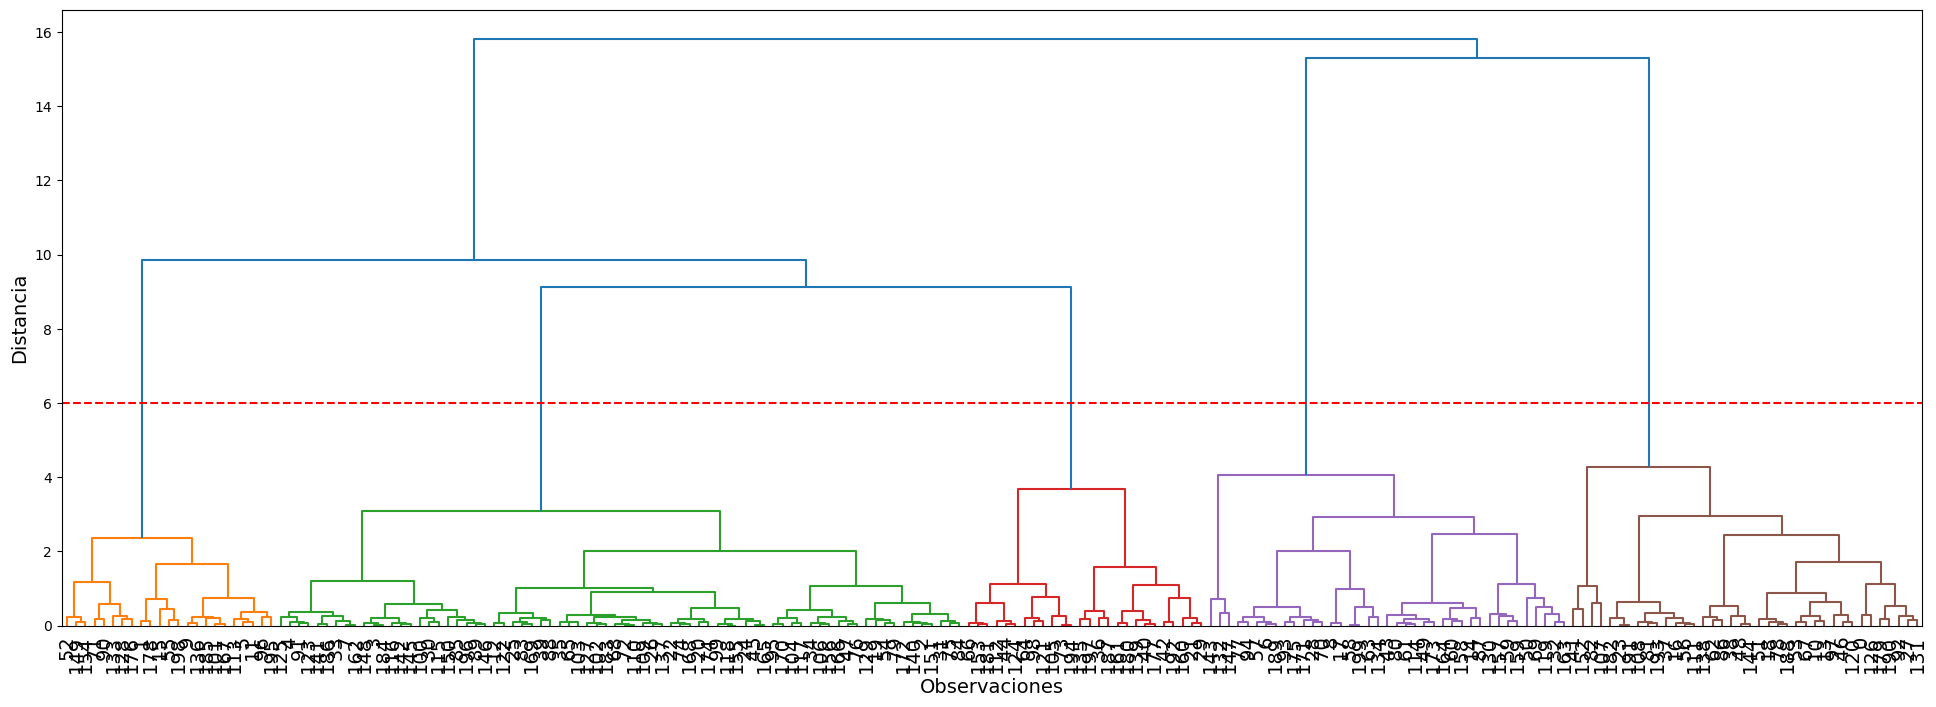

In [107]:
# asignacion de valor de distancia
distancia = 6

fig, ax = plt.subplots(figsize=(24, 8))
# generar el nuevo dendograma teniendo en cuenta la distancia definida anteriormente
d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax,color_threshold=distancia)
ax.axhline(y=distancia, color='r', linestyle='--', label="Distnacia fija en = {d}".format(d=distancia))
ax.set_xlabel('Observaciones', fontsize=14)
ax.set_ylabel('Distancia', fontsize=14)
plt.show()

In [108]:
# se resta uno ya que es el color default de los niveles mas altos a la distancia (color azul)
n_clusters = max(len(set(d["color_list"])) - 1, 1)
print("numero de clusters con la distancia {d}: {c}".format(d=distancia,c=n_clusters))


numero de clusters con la distancia 6: 5


en este caso al definir la distancia para separar clusters como **6** se encuentran **5** clusters, esto se ve de forma grafica al trazar una linea horizontal en el valor 6 y contar cuantas intersecciones existen con las lineas verticales, que representan la magnitud de la distancia entre cada grupo generado, al contar las intersecciones vemos que llegamos al mismo valor de **5**

#### 3.3. Algoritmo Jerárquico Aglomerativo

Utilizando el número de clusters encontrados en el paso anterior, aplique el algoritmo jerárquico aglomerativo, utilizando el enlace 'ward' y la distancia euclidiana. Describa los grupos encontrados, en que grupo o grupos concentraría su estrategia de marketing y por qué?

valor del score de silhouette para metodo agglomerative 0.5367019492775995


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Cluster                          0             1              2             3  \
Ingreso       count      38.000000     26.000000      39.000000     23.000000   
              mean    87055.074474  28274.667308   86537.496410  26230.419565   
              std     16200.102296   8998.503308   16684.184918   7742.413865   
              min     70888.720000  13458.020000   68486.790000  15766.840000   
              25%     75765.510000  19362.520000   75875.515000  19590.810000   
              50%     80570.395000  28787.940000   77996.300000  24905.790000   
              75%     95988.570000  37203.277500   93952.440000  33157.710000   
              max    138584.520000  43155.280000  137838.570000  38950.660000   
Puntaje_Gasto count      38.000000     26.000000      39.000000     23.000000   
              mean       18.631579     23.307692      82.128205     78.565217   
              std        10.915947     13.959281       9.364489     10.953729   
              min         1.000000      3.000000      63.000000     61.000000   
              25%        10.250000     13.250000      74.500000     73.000000   
              50%        16.500000     27.000000      83.000000     77.000000   
              75%        26.750000     35.000000      90.000000     84.500000   
              max        40.000000     42.000000      97.000000     99.000000   

Cluster                         4  
Ingreso       count     74.000000  
              mean   55451.258514  
              std     7847.567060  
              min    40218.680000  
              25%    48594.107500  
              50%    57359.505000  
              75%    61796.637500  
              max    70469.660000  
Puntaje_Gasto count     74.000000  
              mean      50.216216  
              std        5.871385  
              min       40.000000  
              25%       46.000000  
              50%       50.000000  
              75%       55.000000  
              max       60.000000

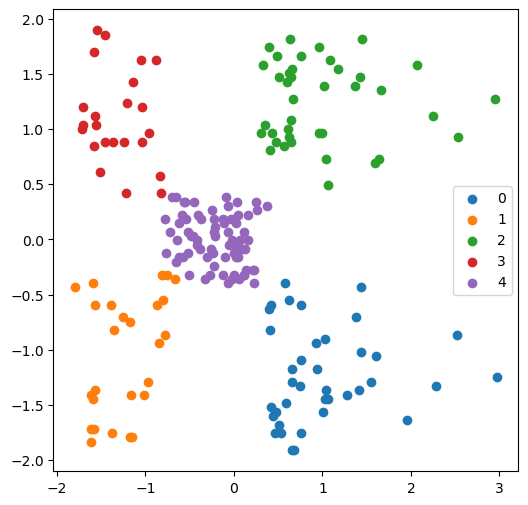

In [109]:
X = df_datos_scaled


# Ejecutar algoritmo
cluster_sk = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
#Nota para quiene esten usando la versión 1.4., la opción affinity fue renombrada a metric
cluster_sk = cluster_sk.fit_predict(X)


# Mostrar resultado del agrupamiento
clusteres = cluster_sk
n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
resultado = pd.DataFrame(X).assign(Cluster = clusteres)

# Calculo del silhouette
silhouette_agglomerative = silhouette_score(X, clusteres, metric="euclidean")
print("valor del score de silhouette para metodo agglomerative {}".format(silhouette_agglomerative))

# Graficar
fig, ax = plt.subplots(figsize=(6,6))

for k in np.unique(clusteres):
    if k != -1:
        ax.scatter(
            x = resultado.loc[resultado.Cluster == k, 0], 
            y = resultado.loc[resultado.Cluster == k, 1],
            label = k
            )
    else:
        ax.scatter(
            x = resultado.loc[resultado.Cluster == k, 0], 
            y = resultado.loc[resultado.Cluster == k, 1],
            c = "black",
            label = k
            )
        
ax.legend()

# Mostrar estadisticas de resultados 
df_resultado_dbscan = pd.concat([df_datos,resultado["Cluster"]], axis=1)
display(df_resultado_dbscan.groupby(["Cluster"])[["Ingreso","Puntaje_Gasto"]].describe().T)

plt.show()


como se evidencia en el analisis descriptivo de las variables se observan 5 grupos, al observar los valores promedio de las variables estos grupos describirse de la siguiente manera:

| Grupo                   | Número | Descripción                                      |
|-------------------------|--------|--------------------------------------------------|
| Central                 | 4      | Personas con ingresos promedio y con un gasto promedio |
| Superior derecho        | 2      | Personas con un alto ingreso y alto gasto         |
| Superior izquierdo      | 3      | Personas con un alto gasto e ingresos bajos       |
| Inferior derecho        | 0      | Personas con alto ingreso y bajo gasto            |
| Inferior izquierdo      | 1      | Personas con bajo ingreso y bajo gasto            |


respecto a estos grupos como se concentraria una estrategia de marketing es complicado definir estrategias sin concer la naturaleza de la tienda que se esta analizando pero a continuacion hay algunas ideas.

| Grupo                | Número | Descripción                                                                                                                                               |
|----------------------|--------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| Central              | 4      | Se pueden trabajar estrategias de profundización de clientes, analizando qué categorías de productos son las de mayor gasto, así se puede incentivar a los clientes para que consuman más de la tienda. |
| Superior derecho     | 2      | Es el grupo ideal ya que tienen altos ingresos y realizan alto gasto; no habría que incentivar el gasto, pero deben monitorearse para identificar posibles desplazamientos a otros clusters. Si esto ocurre, se deben pensar en estrategias de conservación. |
| Superior izquierdo   | 3      | Son clientes que, aunque tienen ingresos bajos, están gastando alto. Para conservarlos, podrían recibir comunicaciones para aprovechar descuentos o promociones en la tienda. |
| Inferior derecho     | 0      | Clientes con alto ingreso y alto costo; debería incentivarse el gasto, tal vez con el mismo tratamiento del grupo anterior: comunicaciones para aprovechar descuentos o promociones. |
| Inferior izquierdo   | 1      | Este grupo es el más complicado, ya que no cuentan con la capacidad para ahorrar. Para conservarlos, podrían ofrecerse programas de fidelización para que no sigan disminuyendo su consumo. |

### 4. DBSCAN

Implemente DBSCAN, al igual que el punto anterior sólo dos variables: su ingreso y el puntaje de gastos. Al implementar  justifique su elección de `min_samples` y `eps`. ¿Cuántos grupos o clusters encuentra? ¿Cuáles son su características? ¿Cambiaría su estrategia de marketing respecto al punto anterior? Justifique su respuesta.

In [110]:
X = df_datos_scaled

funcion para encontrar punto de corte optimo de las distancias entre clusters

In [111]:
def find_knee_points(data, n_neighbors_list, metric='minkowski', graficar=True):
    '''
    funcion que se utiliza para encontrar el punto de maxima inflexion en la curva generada por las distnacias entre puntos, 
    para calcular las distnacias se vale del algoritmo de NearestNeighbors que tiene como parametro de entrada los numeros de vecinos

    devuelve una lista con los valores de inflexion maximos para los n_vecinos de entrada

    parametros:
    data: dataframe con los datos para encontrar las distancias
    n_neighbors: numero de vecinos para el algoritmo de NearesNeighbors
    metric: parametro para el algoritmo de NearesNeighbors, dictamina la funcion que se usará para calcular las distancias
    grafica: booleano que indica si se deben mostrar las graficas de las curvas y puntos de inflexio máximos ingresados como parámetros

    '''
    
    # array de retorno
    knee_values = []
    
    # Definir una lista de colores usando la paleta "tab10"
    colors = plt.cm.tab10(np.linspace(0, 1, len(n_neighbors_list)))
    
    if graficar:
        plt.figure(figsize=(10, 6), dpi=100)
    
    # iterar sibre cada cantidad de vecinos
    for idx, n in enumerate(n_neighbors_list):
        # Crear el modelo de vecinos más cercanos
        neigh = NearestNeighbors(n_neighbors=n, metric=metric)
        nbrs = neigh.fit(data)
        # asignacion de distancias calculadas por el algoritmo de Neighbors
        distancias, indices = nbrs.kneighbors(data)
        distancias = np.sort(distancias.flatten())
        
        # LLamado a metodo para encontrar el punto de inflexion maximo
        i = np.arange(len(distancias))
        knee_locator = KneeLocator(i, distancias, S=1, curve='convex', direction='increasing', interp_method='polynomial')
        
        # Verificar si se encontró un punto de rodilla
        if knee_locator.knee is not None:
            knee_value = distancias[knee_locator.knee]
        else:
            # En caso de que no se encuentre un punto de rodilla
            knee_value = np.nan  
        
        knee_values.append(knee_value)
        

        if graficar:
            # Obtener un color para la línea
            color = colors[idx]
            
            plt.plot(distancias, label=f'n_neighbors = {n}', color=color)
            if not np.isnan(knee_value):
                plt.axhline(y=knee_value, color=color, linestyle='--', label=f'Knee at {n} = {knee_value:.2f}')

    
    if graficar:
        plt.xlabel('Data Points')
        plt.ylabel('Distance')
        plt.title('Knee Point Analysis for Different n_neighbors')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

    return np.array(knee_values)

Demostracion de la funcion declarada previamente. donde el resultado se evidencia gráficamente

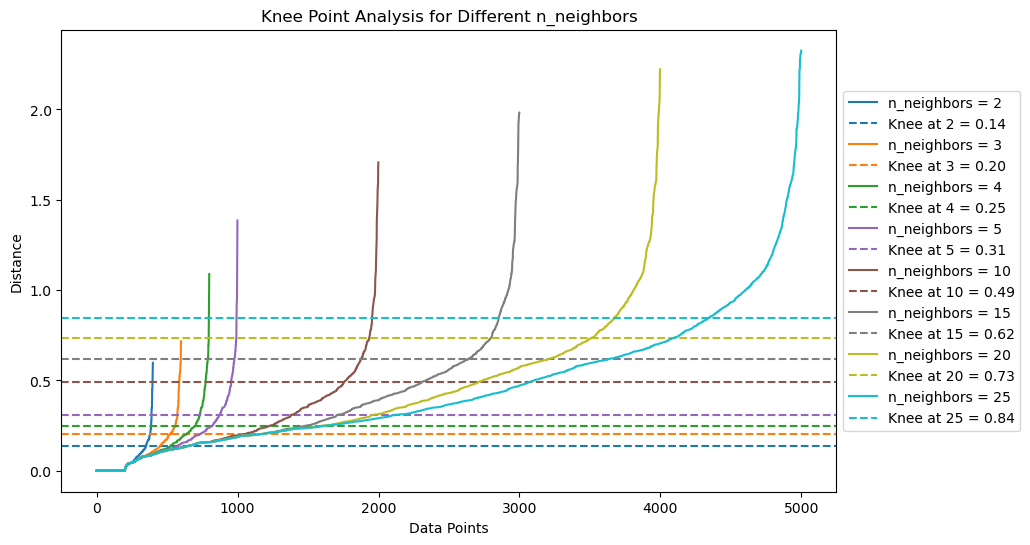

In [112]:
n_neighbors_list = [2, 3, 4, 5, 10, 15, 20, 25]  
epsilon_list = find_knee_points(X, n_neighbors_list)
#neighbors_epsilon=pd.DataFrame({'n_neighbors':n_neighbors_list, 'epsilon':epsilon_list})

A continuacion se realiza realiza la busqueda del valor de la distancia donde la magnitud de la separacion entre vecinos aumenta de forma exponencial. 

En este caso el rango de vecinos que nos han recomendado por default es igual 4 dado que solo hay 2 dimensiones, sin embargo se iterarán distintos valores arrancando desde 2 y terminando en 15 con pasos de 1.

(inicialmente se probo un valor máximo mas alto sin embargo despues de un valor solo se llega a tener un unico cluster, por consiguiente ya no vale la pena seguir evaluando, por este motivo se eligió "a priori" entre 2 y 15 vecinos.)

In [113]:
# Definicion del limite superior para la iteracion de vecinos
#limite_sup = int(np.ceil(len(X)/4)) 
limite_sup = 15

# crea el array con la lista completa de vecinos que se quiere encontrar
n_neighbors_list = np.arange(2,limite_sup,1)

# llamado a la funcion 
epsilon_list = find_knee_points(X, n_neighbors_list,graficar=False)

# resultado
neighbors_epsilon=pd.DataFrame({'n_neighbors':n_neighbors_list, 'epsilon':epsilon_list})
neighbors_epsilon

n_neighbors   epsilon
0             2  0.138260
1             3  0.203458
2             4  0.246229
3             5  0.310153
4             6  0.351759
5             7  0.388261
6             8  0.420453
7             9  0.457896
8            10  0.493497
9            11  0.524894
10           12  0.547574
11           13  0.582300
12           14  0.601132

In [114]:
def itera_clusters(df_info, iteraciones, metrica="euclidean",df_distancias=None):
    '''
    funcion que muestra los clusters formados por la combinacion de distintos parametros de eps y min_samples en la funcion DBSCAN,
    adicionalmente calcula el score de Silhouette para los cluster formados

    parametros:
    df_info: dataset con los datos cuantitativos originales en dos dimensiones
    iteraciones: array con la combinacion de parametros de eps y min_samples a probar
    metrica: metrica a aplicar en los algoritmos de DBSCAN y calculo de Solhouette
    df_distancias: dataframe con las distancias entre todos los puntos
    
    '''
    # incializacion del arreglo de salida
    arr_silhouettes = []

    # funcion que asigna como variable X las distancias entre puntos cuando la metrica es precomputed, de lo contrario X sera los datos de entrada
    if metrica == "precomputed":
        X = df_distancias
    else:
        X = df_info
    
    # parametros para las graficas
    n_cols = 5
    n_rows = int(np.ceil(len(iteraciones)/n_cols))

    fig, ax = plt.subplots(n_rows, n_cols,figsize=(n_cols*6,n_rows*6))
    axs = ax.flatten()

    # iteracion sobre los parametros 
    for i,(eps,min_samples) in enumerate(iteraciones):
        
        # Ejecucion del algoritmo DBSCAN
        db = DBSCAN(eps = eps, min_samples = min_samples, metric=metrica).fit(X)
        # Extraccion de los label de los cluster
        clusteres = db.labels_
        # Calculo de la cantidad de clusteres encontrados por DBSCAN
        n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
        
        # Genera un dataframe resultado con los datos "originales" mas una columna con los labels de los cluster encontrados
        resultado = pd.DataFrame(df_info).assign(Cluster = clusteres)
        
        # calculo del score de silhouette
        silhouette = silhouette_score(X, clusteres, metric=metrica)
        arr_silhouettes.append(silhouette)

        
        # Grafica de cada grupo encontrado por DBSCAN
        for k in np.unique(clusteres):
            if k != -1:
                axs[i].scatter(
                    x = resultado.loc[resultado.Cluster == k, 0], 
                    y = resultado.loc[resultado.Cluster == k, 1]
                    )
            else:
                axs[i].scatter(
                    x = resultado.loc[resultado.Cluster == k, 0], 
                    y = resultado.loc[resultado.Cluster == k, 1],
                    c = "black"
                    )
                
        axs[i].set_title("param: eps:{e:.4f} ,min_samples:{s}, neighbors:{n}".format(e=np.round(eps,2),s=min_samples,n=n_clusteres))
                
    # Remover axis de graficas no utilizadas
    for j in range(i + 1, n_rows * n_cols):
        axs[j].axis('off')


    return arr_silhouettes

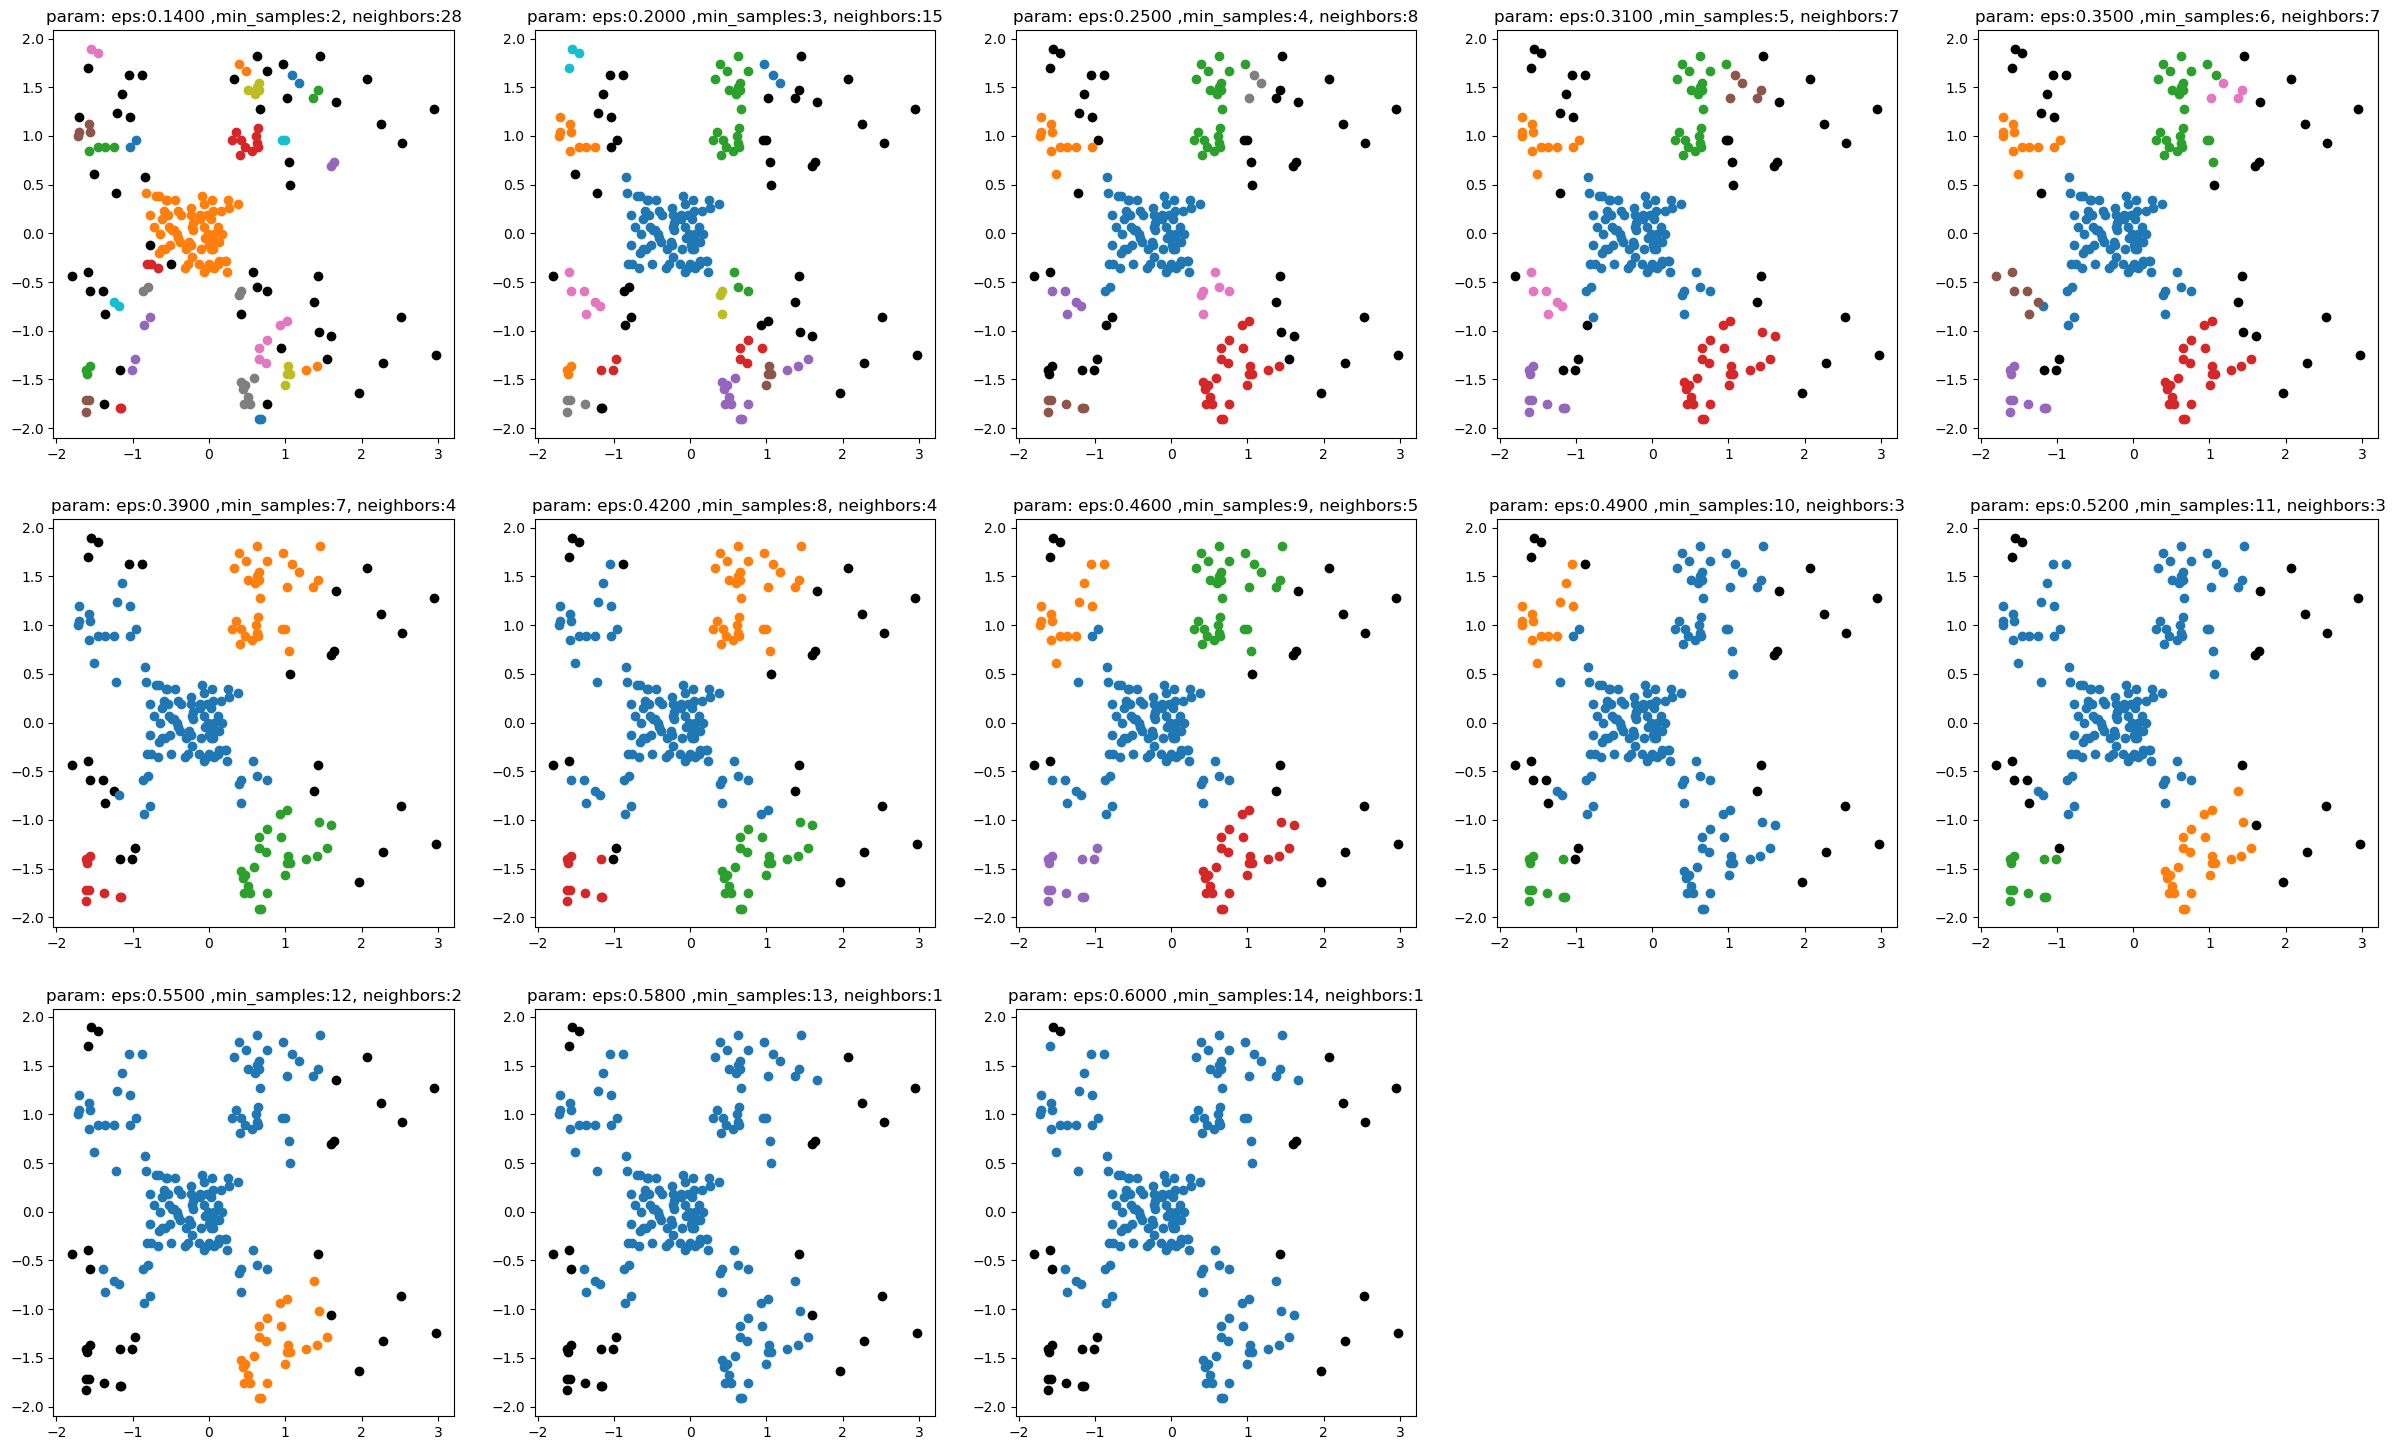

In [115]:
# genera las combinaciones de valores que serán buscadas, en este caso son la lista de vecinos mas los epsilon optimos encontrados anteriormente 
iteraciones_dbscan_cuantitativo = list(zip(epsilon_list,n_neighbors_list))

# llamado a la funcion 
silhoutte_dbscan_cuantitativo = itera_clusters(X, iteraciones_dbscan_cuantitativo )

En las gráficas anteriores se ven los distintos cluster formados para todos los pares de parametros probados, para elegir la mejor agrupacion utilizaremos la metrica de **silhouette**, en donde un valor mas alto será mejor.

In [116]:
# seleccion del mejor par de parametros, a traves del score de silhouette mas alto
best_dbscan_cuantitativo = iteraciones_dbscan_cuantitativo[np.argmax(silhoutte_dbscan_cuantitativo)]

print("La mejor combinacion de parámetros para la generacion de clusters es:")
print("param: eps:{e} ,min_samples:{s}".format(e=np.round(best_dbscan_cuantitativo[0],6),s=best_dbscan_cuantitativo[1]))
print("valor de silhouette maximo:{s}".format(s=silhoutte_dbscan_cuantitativo[np.argmax(silhoutte_dbscan_cuantitativo)]))

La mejor combinacion de parámetros para la generacion de clusters es:
param: eps:0.457896 ,min_samples:9
valor de silhouette maximo:0.441277865416821


Se ha encontrado un par de parametros optimos, sin embargo para rectificar se plantean mas iteraciones con algunas de las distancias optimas encontradas anteriormente

In [117]:
# seleccion del min_samples optimos
min_samples_optimo = best_dbscan_cuantitativo[1]

# se encuentran los indices de los min_samples que estan entre +/- 3 del valor oprimo de vecinos
idx_lst = np.where((n_neighbors_list >= min_samples_optimo - 3 ) & (n_neighbors_list <= min_samples_optimo+3))[0]

# se recupera una lista de los n_neighbors a partir de los indices identificados anteriormente
list_neighbors = n_neighbors_list[idx_lst]

# se recupera una lista con los epsilon optimos de los n_neighbors a partir de los indices identificados anteriormente
list_epsilons = epsilon_list[idx_lst]

# se crea una nueva lista con la combinatoria de todos los elementos de la lista de neighbors con la lista de epsilon
combinations_iter2 = [(x, y) for x in list_epsilons for y in list_neighbors]

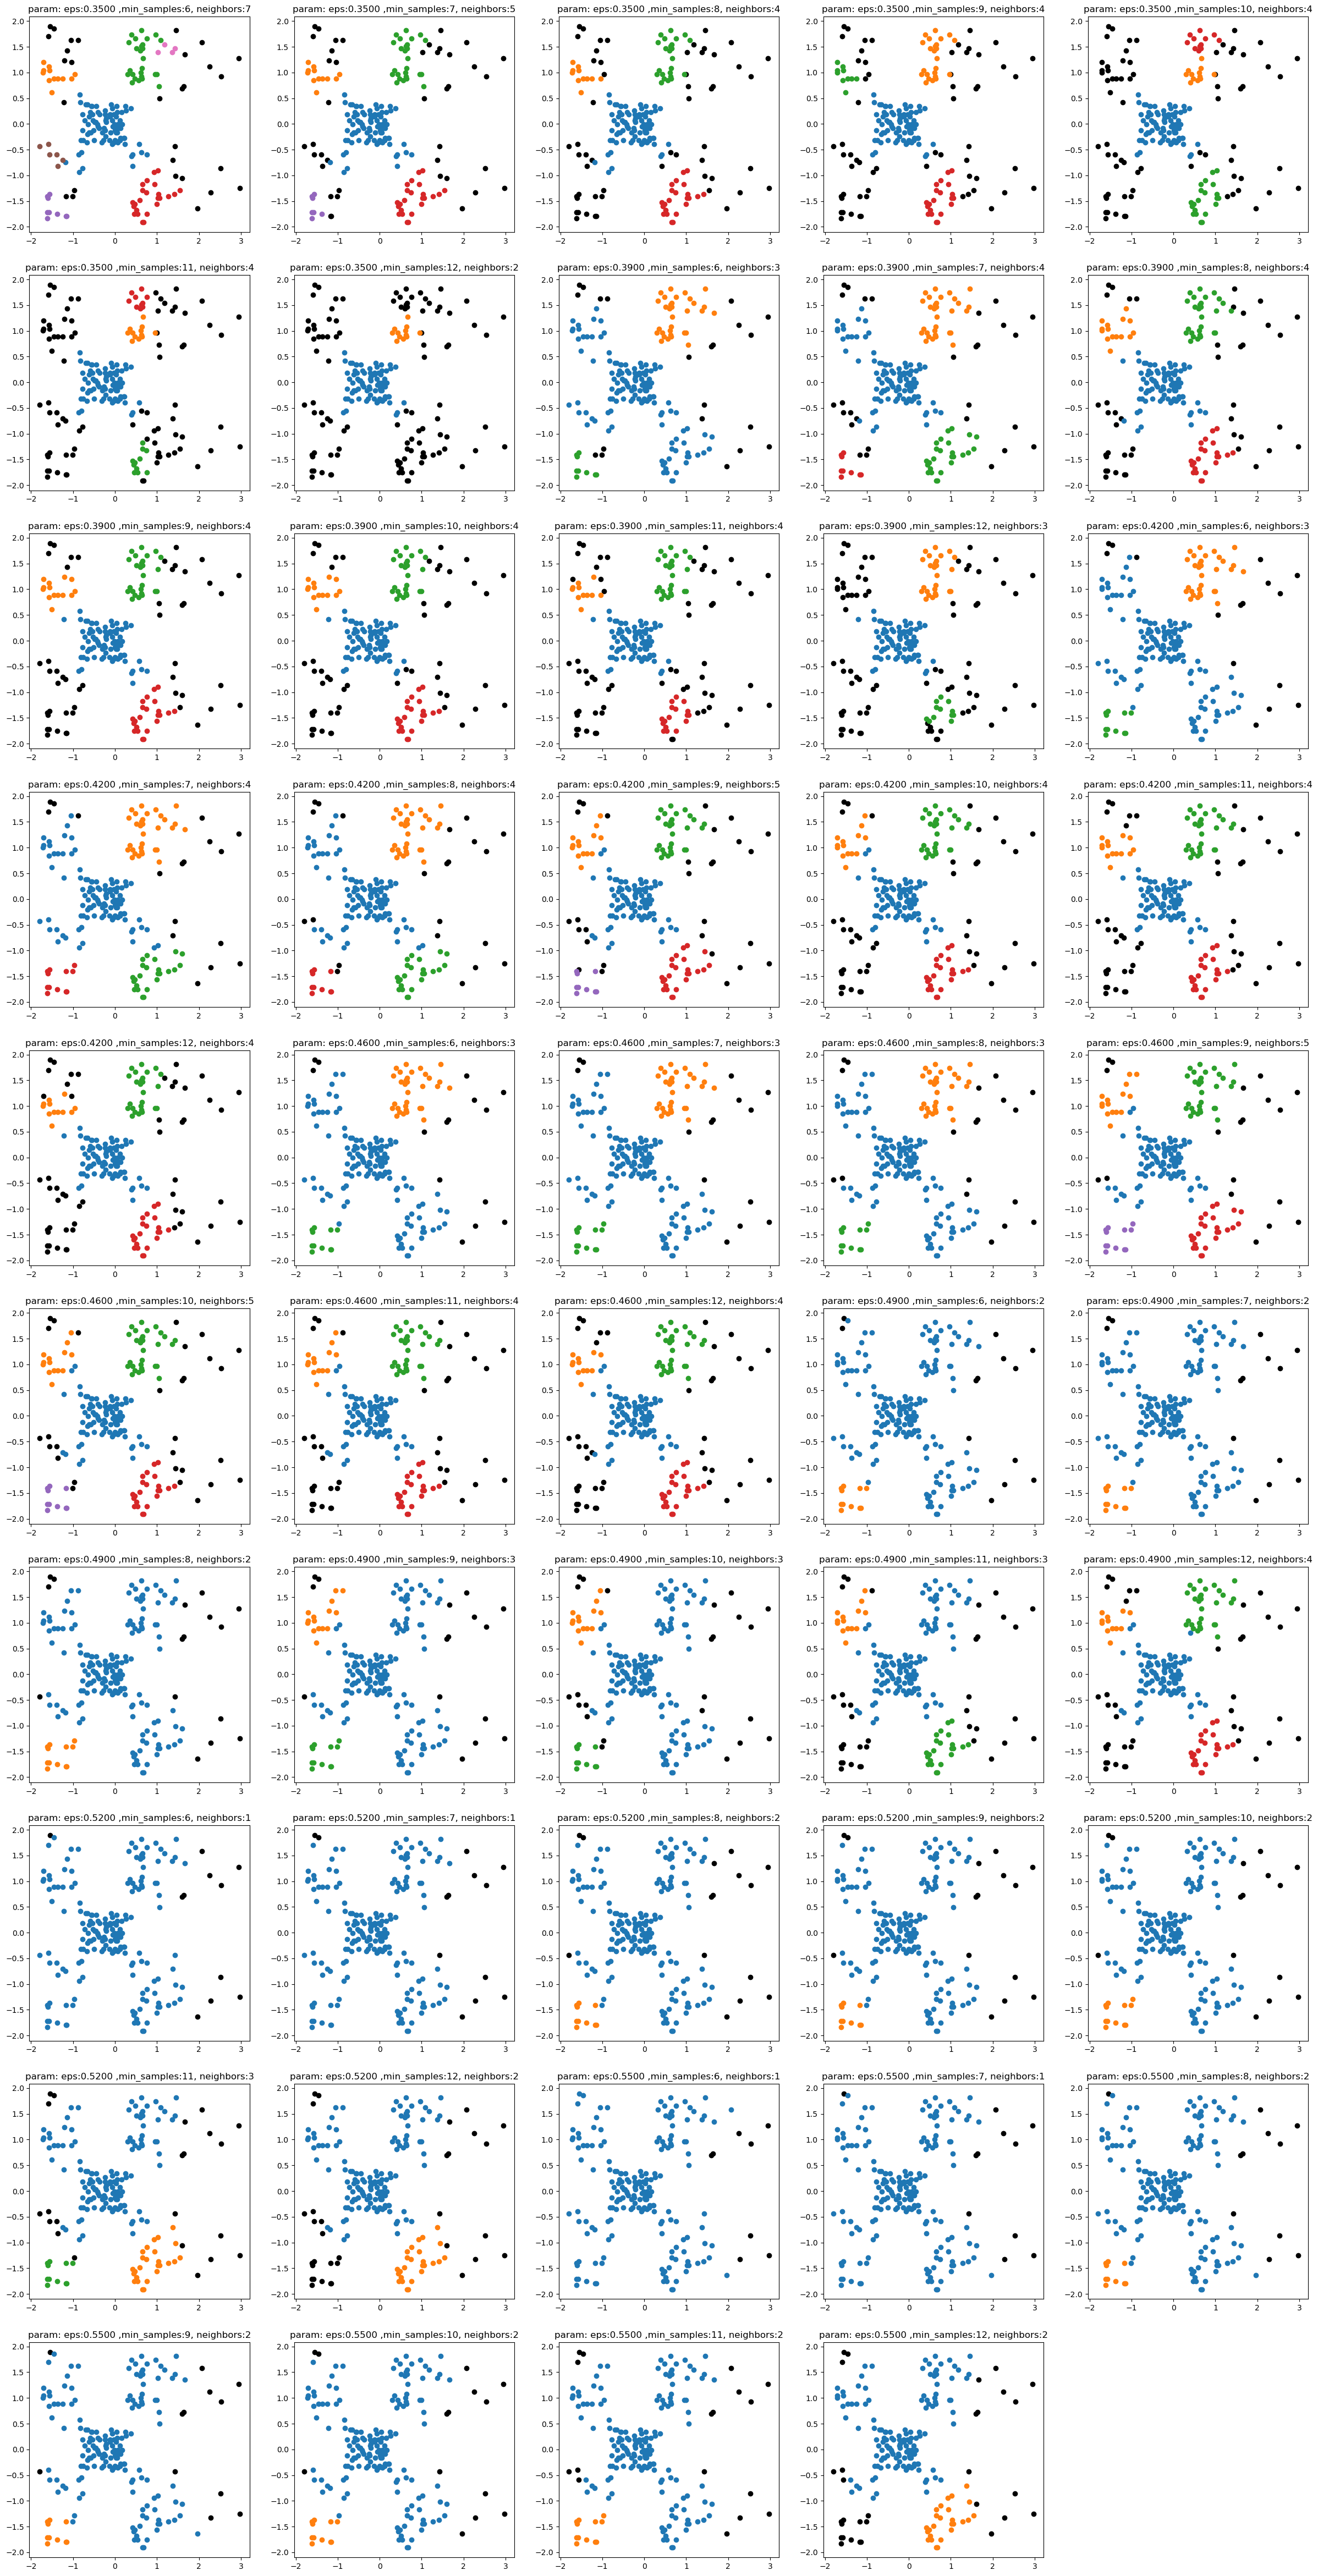

In [118]:
# Generacion de los cluster y la metrica de silhoutte para cada parametro de la lista de combinaciones_iter2
silhoutte_dbscan_cuantitativo2 = itera_clusters(X, combinations_iter2 )

Nuevamente se ven los cluster formados para los datos de entrada, con los distintos pares de parametros, nuevamente se utilizará el score de solhouette para seleccionar el mejor

In [119]:
best_dbscan_cuantitativo = combinations_iter2[np.argmax(silhoutte_dbscan_cuantitativo2)]

print("La mejor combinacion de parámetros para la generacion de clusters es:")
print("param: eps:{e} ,min_samples:{s}".format(e=np.round(best_dbscan_cuantitativo[0],6),s=best_dbscan_cuantitativo[1]))
print("valor de silhouette maximo:{s}".format(s=silhoutte_dbscan_cuantitativo2[np.argmax(silhoutte_dbscan_cuantitativo2)]))

La mejor combinacion de parámetros para la generacion de clusters es:
param: eps:0.457896 ,min_samples:9
valor de silhouette maximo:0.441277865416821


se obtiene el mismo resultado que en la iteracion anterior, por ello a continuacion se muestra el resultado de la agrupacion

valor del score de silhouette para metodo agglomerative 0.441277865416821


Cluster                         -1             0             1             2  \
Ingreso       count      19.000000     97.000000     15.000000     31.000000   
              mean    88650.743684  52900.312887  24431.793333  79906.826452   
              std     44879.791562  12331.311623   7122.519479   8550.032357   
              min     13458.020000  19604.830000  15766.840000  68486.790000   
              25%     55455.960000  44346.140000  19391.570000  73623.060000   
              50%    103654.790000  54589.350000  22531.850000  77373.890000   
              75%    119977.490000  61886.710000  29942.750000  86220.270000   
              max    138584.520000  80565.010000  37682.870000  98635.760000   
Puntaje_Gasto count      19.000000     97.000000     15.000000     31.000000   
              mean       59.105263     48.164948     78.733333     83.580645   
              std        30.208341      9.422580      7.372407      8.879843   
              min         8.000000     26.000000     66.000000     69.000000   
              25%        35.500000     42.000000     73.000000     75.000000   
              50%        68.000000     48.000000     77.000000     86.000000   
              75%        84.000000     55.000000     81.500000     90.500000   
              max        99.000000     75.000000     92.000000     97.000000   

Cluster                          3             4  
Ingreso       count      26.000000     12.000000  
              mean    83410.828462  24743.731667  
              std      9321.025556   6706.493385  
              min     71651.080000  18284.380000  
              25%     76383.175000  18707.172500  
              50%     80468.215000  22009.995000  
              75%     87681.985000  30209.575000  
              max    102643.750000  35034.660000  
Puntaje_Gasto count      26.000000     12.000000  
              mean       13.769231      9.583333  
              std         7.361020      5.282188  
              min         1.000000      3.000000  
              25%         9.250000      4.750000  
              50%        13.500000      9.500000  
              75%        19.250000     14.000000  
              max        27.000000     17.000000

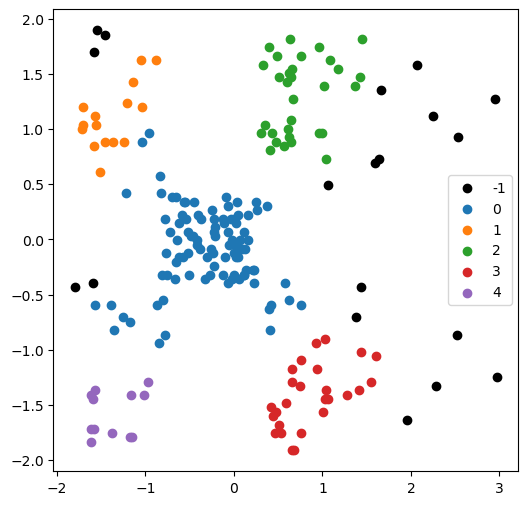

In [120]:
X = df_datos_scaled

# generacion de agrupamiento con los mejores parametros
db = DBSCAN(eps = best_dbscan_cuantitativo[0], min_samples = best_dbscan_cuantitativo[1], metric="euclidean").fit(X)
clusteres = db.labels_
n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
resultado = pd.DataFrame(X).assign(Cluster = clusteres)

# calculo de silhouette
silhouette_dbscan_cuantitativo = silhouette_score(X, clusteres, metric="euclidean")
print("valor del score de silhouette para metodo agglomerative {}".format(silhouette_dbscan_cuantitativo))

fig, ax = plt.subplots(figsize=(6,6))


for k in np.unique(clusteres):
    if k != -1:
        ax.scatter(
            x = resultado.loc[resultado.Cluster == k, 0], 
            y = resultado.loc[resultado.Cluster == k, 1],
            label = k
            )
    else:
        ax.scatter(
            x = resultado.loc[resultado.Cluster == k, 0], 
            y = resultado.loc[resultado.Cluster == k, 1],
            c = "black",
            label = k
            )
        
ax.legend()


df_resultado_dbscan = pd.concat([df_datos,resultado["Cluster"]], axis=1)
display(df_resultado_dbscan.groupby(["Cluster"])[["Ingreso","Puntaje_Gasto"]].describe().T)

plt.show()

Bajo esta metodologia se obtienen 5 grupos, sin contar el de outliers. Al ver los valores descriptivos de este se ve que como fue evidenciado en los analisis posteriores se encuentran los 4 grupos descirtos anteriormente:

| Grupo                   | Número | Descripción                                      |
|-------------------------|--------|--------------------------------------------------|
| Central                 | 0      | Personas con ingresos promedio y con un gasto promedio |
| Superior derecho        | 2      | Personas con un alto ingreso y alto gasto         |
| Superior izquierdo      | 1      | Personas con un alto gasto e ingresos bajos       |
| Inferior derecho        | 3      | Personas con alto ingreso y bajo gasto            |
| Inferior izquierdo      | 4      | Personas con bajo ingreso y bajo gasto            |


Al ser la misma cantidad de grupos con las mismas caracteristicas <span style="font-size: 20px; color: red;">**no cambiaria**</span> la estrategia de marketing, que siguie siendo la que se ilustrará en la tabla siguiente, adicionalmente dependiendo de la estrategia y de los recursos de la tienda **preferiria utilizar el clustering agglomerativo** ya que este asigna a todas las observaciones a un cluster lo que en ciertas ocaciones puede ser mejor que dejar observaciones sin grupo (outliers)

| Grupo                | Número | Descripción                                                                                                                                               |
|----------------------|--------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| Central              | 0      | Se pueden trabajar estrategias de profundización de clientes, analizando qué categorías de productos son las de mayor gasto, así se puede incentivar a los clientes para que consuman más de la tienda. |
| Superior derecho     | 2      | Es el grupo ideal ya que tienen altos ingresos y realizan alto gasto; no habría que incentivar el gasto, pero deben monitorearse para identificar posibles desplazamientos a otros clusters. Si esto ocurre, se deben pensar en estrategias de conservación. |
| Superior izquierdo   | 1      | Son clientes que, aunque tienen ingresos bajos, están gastando alto. Para conservarlos, podrían recibir comunicaciones para aprovechar descuentos o promociones en la tienda. |
| Inferior derecho     | 3      | Clientes con alto ingreso y alto costo; debería incentivarse el gasto, tal vez con el mismo tratamiento del grupo anterior: comunicaciones para aprovechar descuentos o promociones. |
| Inferior izquierdo   | 4      | Este grupo es el más complicado, ya que no cuentan con la capacidad para ahorrar. Para conservarlos, podrían ofrecerse programas de fidelización para que no sigan disminuyendo su consumo. |

### 5. Incorporando más dimensiones

Hasta este momento hemos utilizado solo dos variables para nuestro análisis, sin embargo, la base cuenta con otras variables más: género y edad. Usando las categorías de edad creadas anteriormente incorpore género y grupo etario a su análisis. Genere los grupos utilizando DBSCAN y la distancia de Gower, justificando su elección de `min_samples` y `eps`   ¿Incorporar estas variables, ayuda a la focalización de la estrategia de marketing?

In [121]:
# se crea el dataset con la informacion categorica
df_datos_scaled_categ = pd.concat([df_datos_scaled,df_datos[["Genero","rango_edades"]]], axis=1)

# se calculan las distancias con la metrica gower
distancias_gower = gower.gower_matrix(df_datos_scaled_categ)
pd.DataFrame(distancias_gower)

0         1         2         3         4         5         6    \
0    0.000000  0.467024  0.367225  0.629724  0.395525  0.733005  0.381504   
1    0.467024  0.000000  0.349799  0.587300  0.321499  0.526185  0.335520   
2    0.367225  0.349799  0.000000  0.532907  0.283402  0.615780  0.332659   
3    0.629724  0.587300  0.532907  0.000000  0.515800  0.353281  0.615567   
4    0.395525  0.321499  0.283402  0.515800  0.000000  0.337481  0.116061   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.491610  0.289892  0.374385  0.611886  0.096085  0.263707  0.120310   
196  0.374453  0.342571  0.308248  0.525341  0.274847  0.608552  0.390908   
197  0.408111  0.624760  0.622518  0.339611  0.589117  0.348575  0.705178   
198  0.435238  0.031786  0.318013  0.555514  0.289713  0.547767  0.349652   
199  0.114951  0.352072  0.354314  0.637222  0.387716  0.628258  0.271655   

          7         8         9    ...       190       191       192  \
0    0.654588  0.582437  0.503569  ...  0.299865  0.386479  0.152487   
1    0.312435  0.651502  0.036545  ...  0.516888  0.774423  0.380864   
2    0.537363  0.618029  0.386344  ...  0.417090  0.674624  0.366894   
3    0.274864  0.400937  0.623845  ...  0.679589  0.437123  0.583987   
4    0.516446  0.401431  0.358044  ...  0.195389  0.702924  0.333493   
..        ...       ...       ...  ...       ...       ...       ...   
195  0.587022  0.426088  0.263551  ...  0.291475  0.799009  0.405450   
196  0.541293  0.676278  0.379116  ...  0.424318  0.681852  0.308646   
197  0.355563  0.490548  0.615867  ...  0.687567  0.195101  0.301542   
198  0.280649  0.635022  0.068331  ...  0.485102  0.742637  0.349902   
199  0.621270  0.549429  0.388618  ...  0.414816  0.455201  0.221209   

          193       194       195       196       197       198       199  
0    0.637416  0.724295  0.491610  0.374453  0.408111  0.435238  0.114951  
1    0.503077  0.690945  0.289892  0.342571  0.624760  0.031786  0.352072  
2    0.653278  0.688703  0.374385  0.308248  0.622518  0.318013  0.354314  
3    0.415777  0.405795  0.611886  0.525341  0.339611  0.555514  0.637222  
4    0.681578  0.655301  0.096085  0.274847  0.589117  0.289713  0.387716  
..        ...       ...       ...       ...       ...       ...       ...  
195  0.777663  0.695887  0.000000  0.367157  0.603908  0.306372  0.391965  
196  0.660506  0.380454  0.367157  0.000000  0.564270  0.310785  0.412563  
197  0.423755  0.341979  0.603908  0.564270  0.000000  0.605526  0.476833  
198  0.471291  0.671710  0.306372  0.310785  0.605526  0.000000  0.371307  
199  0.706138  0.793017  0.391965  0.412563  0.476833  0.371307  0.000000  

[200 rows x 200 columns]

se procede a realizar nuevamente la busqueda de los parametros de epsilon optimos para un distintos valores de vecinos, en este caso nuevamente se vuelve a iterar en valores entre 2 y 15 con pasos de 1, en este arreglo estaría incluido el valor recomendado de $2*dim$ (8 en este caso).

Utilizamos la funcion antes descrita con el cambio del paramerto metric, ahora se utilizara el <span style="color: orange;">precomputed</span> ya que se cuenta con la matriz de distancias (gower) del set de datos

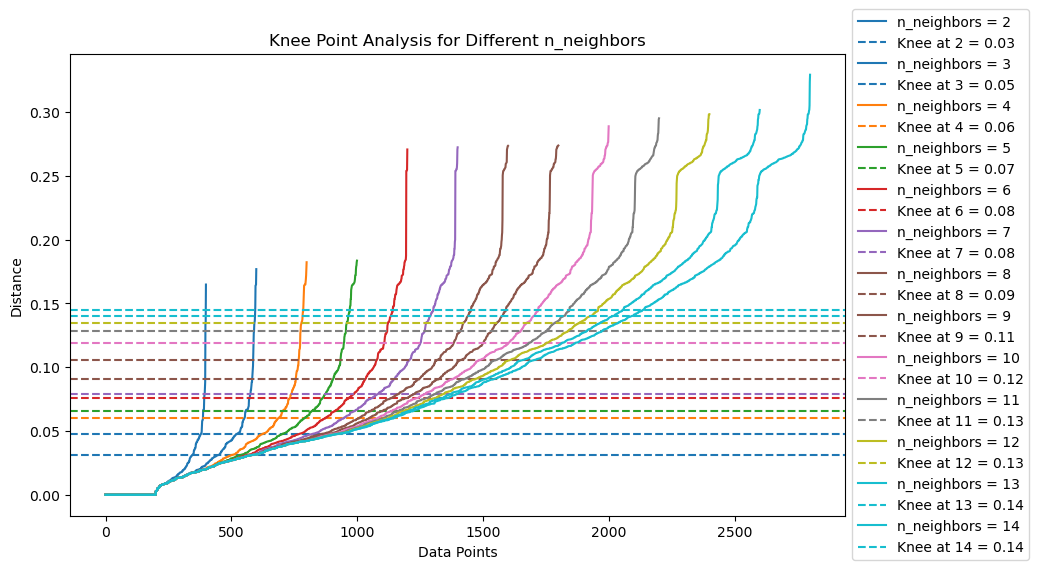

In [122]:
n_neighbors_list_gower = np.arange(2,limite_sup,1)
epsilon_list_gower = find_knee_points(distancias_gower, n_neighbors_list_gower, metric='precomputed', graficar=True)

Una vez encontrados los parametros optimos para valor de vecinos se crean las combinaciones para aplicar la funcion donde se muestran los cluster formados con estos parametros mas el valor del score solhouette para cada uno de ellos

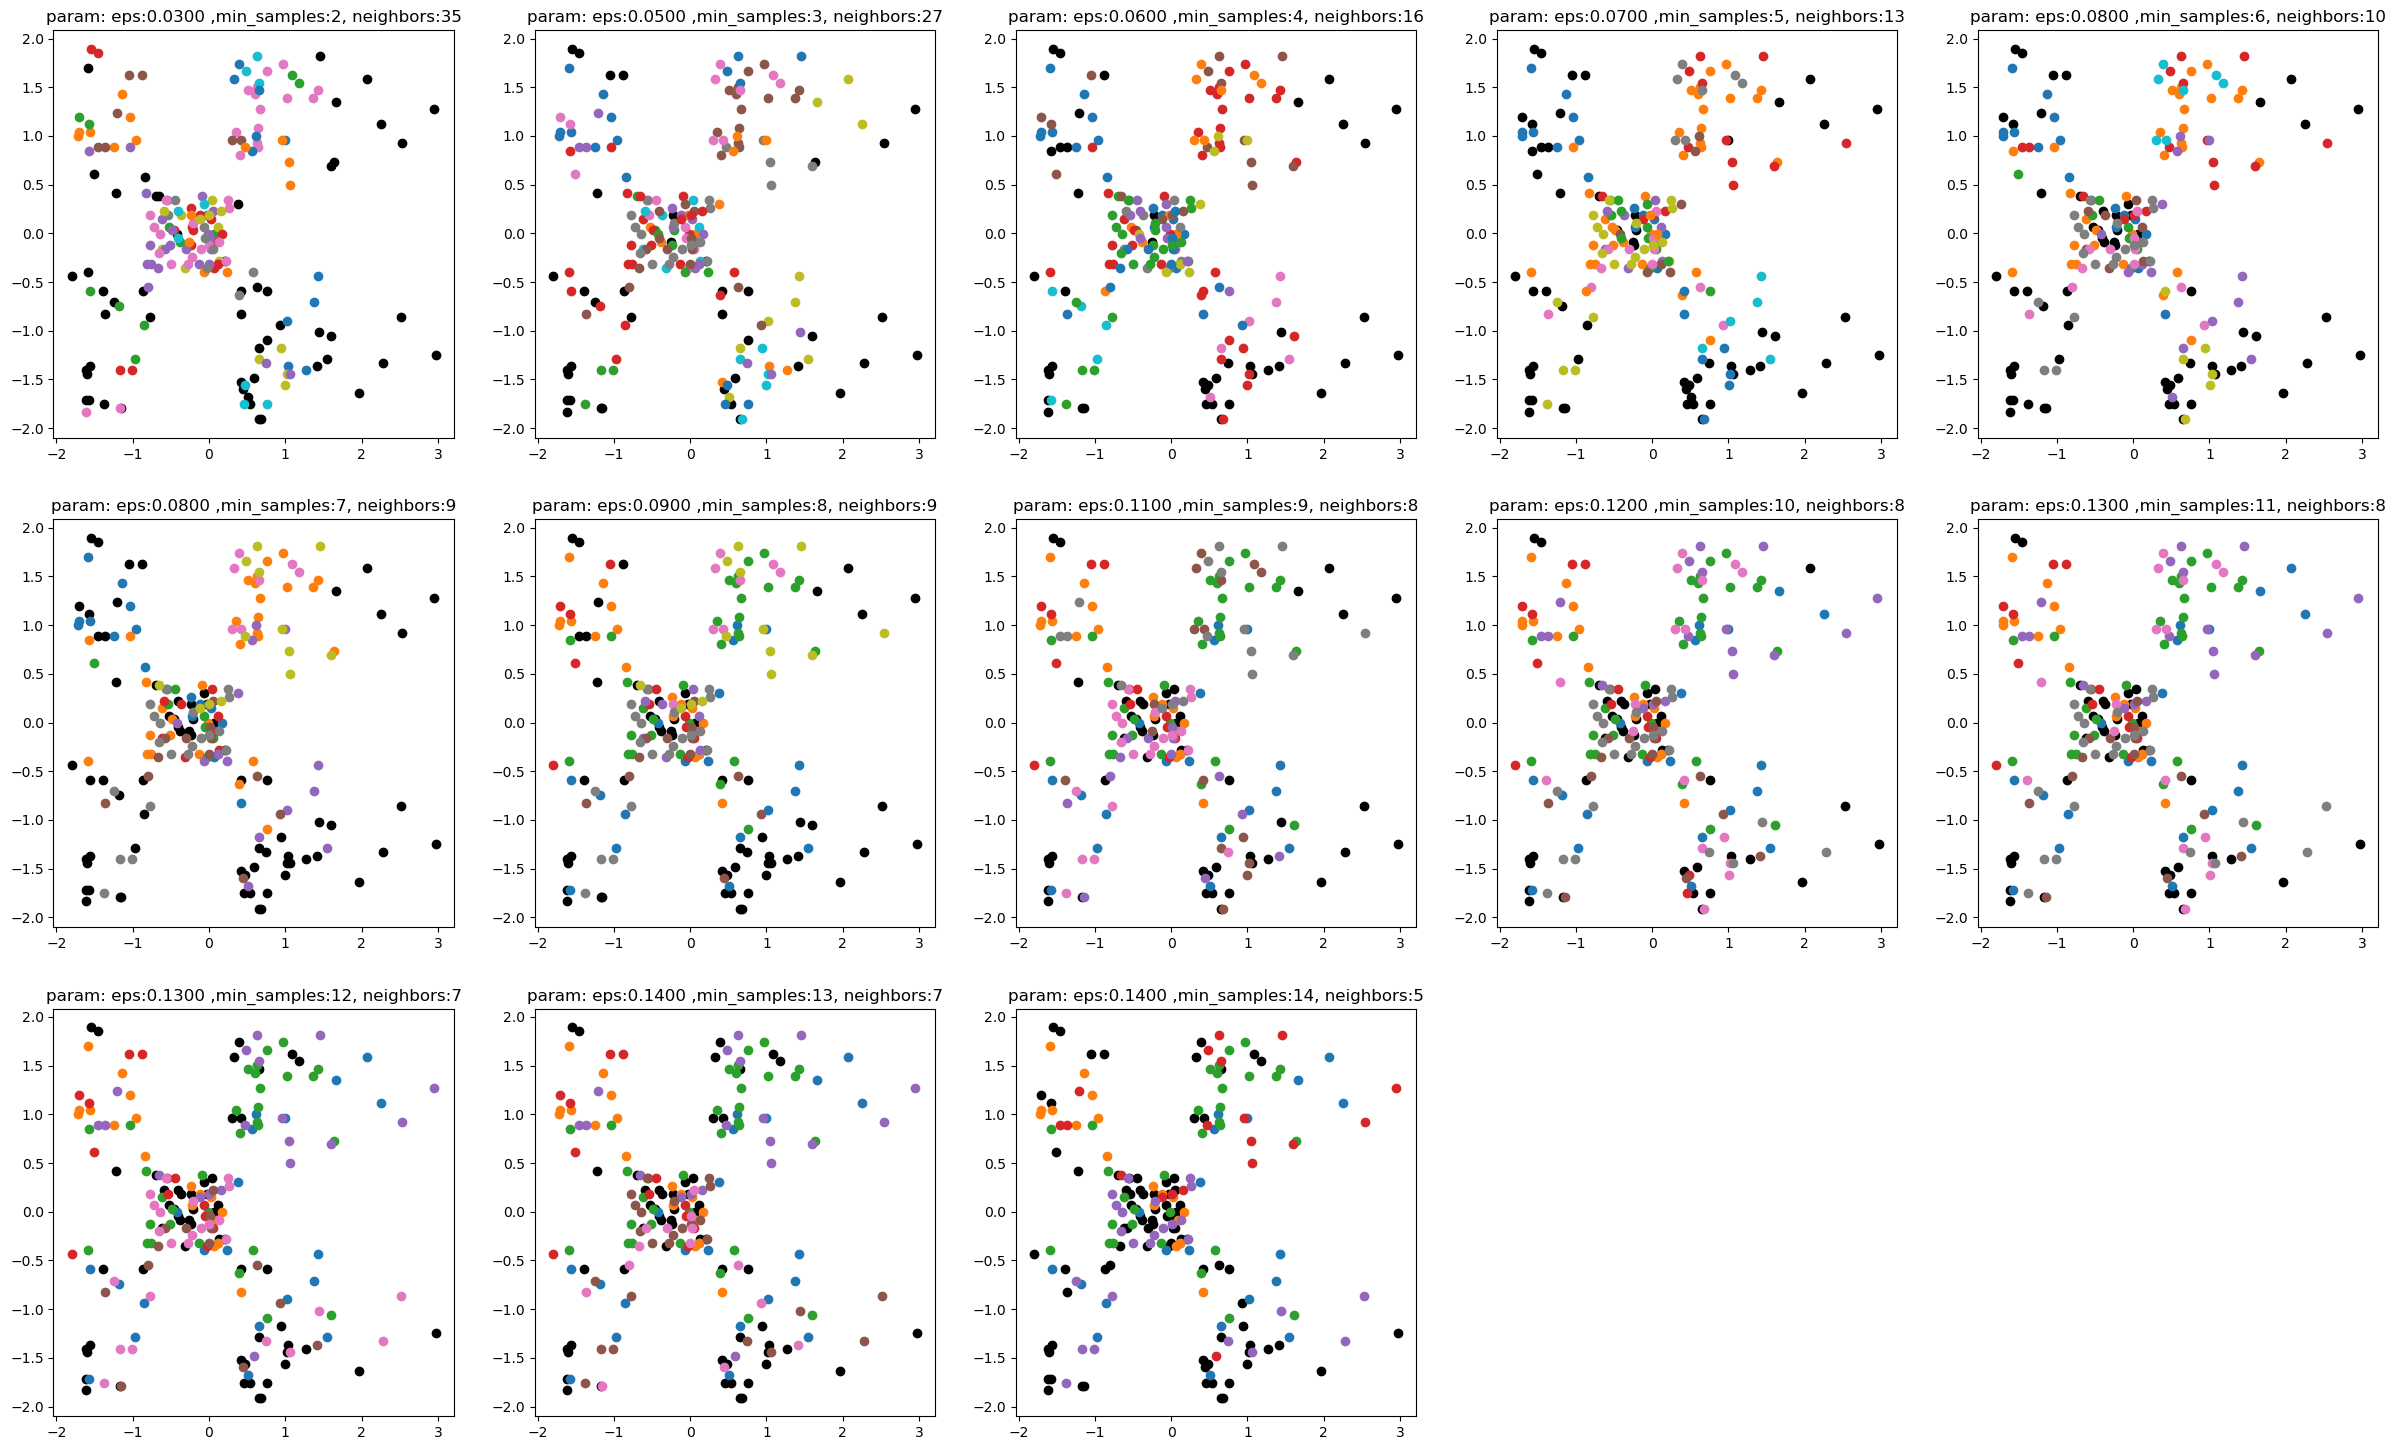

In [123]:
combinaciones_prueba_gower = list(zip(epsilon_list_gower ,n_neighbors_list_gower))
arr_silhouettes_gower = itera_clusters(df_datos_scaled_categ, combinaciones_prueba_gower, metrica="precomputed",df_distancias=distancias_gower)

Como ya hemos visto los graficos anteriores ilustran los grupos formados para los distintos pares de parametros probados, en este caso al incorporar mas de 2 dimensiones la visualizacion se dificulta y esto logra que se vean grupos "menos" uniformes pero esto es debido a que no estamos viendo las otras 2 dimensiones utilizadas. 

Nuevamente utilizaremos el silhouette score para determinar cual es la mejor agrupacion

In [124]:

best_dbscan_cuantitativo = combinaciones_prueba_gower[np.argmax(arr_silhouettes_gower)]

print("La mejor combinacion de parámetros para la generacion de clusters es:")
print("param: eps:{e} ,min_samples:{s}".format(e=np.round(best_dbscan_cuantitativo[0],6),s=best_dbscan_cuantitativo[1]))
print("valor de silhouette maximo:{s}".format(s=silhoutte_dbscan_cuantitativo2[np.argmax(silhoutte_dbscan_cuantitativo2)]))

La mejor combinacion de parámetros para la generacion de clusters es:
param: eps:0.12852400541305542 ,min_samples:11
valor de silhouette maximo:0.441277865416821


Los valores de la mejor combinacion se utilizarán ahora para graficar el resutlado

valor del score de silhouette para metodo agglomerative 0.47997283935546875


Cluster                         -1              0             1  \
Ingreso       count      41.000000      22.000000     18.000000   
              mean    56871.513902   71073.037273  43869.874444   
              std     26010.186027   29563.397008  19403.631196   
              min     18284.380000   19281.750000  15766.840000   
              25%     44346.140000   51997.102500  28675.170000   
              50%     54960.600000   74700.705000  46426.885000   
              75%     72748.560000   94355.725000  61927.732500   
              max    138584.520000  119534.680000  71427.640000   
Puntaje_Gasto count      41.000000      22.000000     18.000000   
              mean       35.268293      43.863636     62.944444   
              std        25.173423      25.848083     17.899958   
              min         1.000000       6.000000     29.000000   
              25%        12.000000      26.250000     50.500000   
              50%        43.000000      39.500000     61.000000   
              75%        52.000000      68.500000     76.750000   
              max        99.000000      91.000000     94.000000   

Cluster                          2             3              4             5  \
Ingreso       count      32.000000     13.000000      18.000000     14.000000   
              mean    65815.380000  40133.600769   74008.443333  58029.127143   
              std     23049.652497  17965.010783   31999.733071  20522.769162   
              min     19003.520000  13458.020000   22531.850000  24993.780000   
              25%     46428.232500  20989.640000   58380.715000  43724.237500   
              50%     72515.755000  46278.660000   75213.745000  60761.560000   
              75%     78621.062500  58724.710000   88242.815000  69593.585000   
              max    103654.790000  61886.710000  137838.570000  97525.800000   
Puntaje_Gasto count      32.000000     13.000000      18.000000     14.000000   
              mean       63.656250     62.307692      74.166667     34.357143   
              std        21.413908     18.318409      13.904083     15.775381   
              min        22.000000     39.000000      54.000000      4.000000   
              25%        45.750000     49.000000      64.250000     26.750000   
              50%        70.000000     59.000000      73.000000     38.500000   
              75%        83.750000     79.000000      82.750000     46.000000   
              max        95.000000     92.000000      97.000000     56.000000   

Cluster                         6              7  
Ingreso       count     17.000000      25.000000  
              mean   69837.564118   59210.614800  
              std    19598.308322   26541.550152  
              min    24086.950000   24402.320000  
              25%    68486.790000   41739.840000  
              50%    71752.690000   54827.740000  
              75%    85345.900000   67219.480000  
              max    91426.180000  126685.780000  
Puntaje_Gasto count     17.000000      25.000000  
              mean      53.000000      37.280000  
              std       33.137969      16.754402  
              min        1.000000       5.000000  
              25%       20.000000      24.000000  
              50%       55.000000      43.000000  
              75%       88.000000      50.000000  
              max       95.000000      59.000000

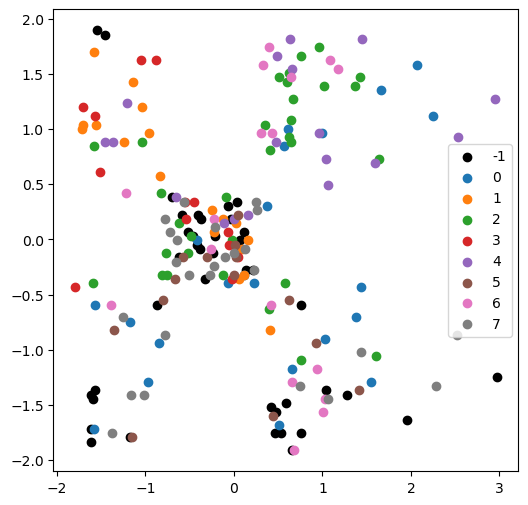

In [125]:
X = distancias_gower

#Calculo de los grupos con las mejores configuraciones
db = DBSCAN(eps = best_dbscan_cuantitativo[0], min_samples = best_dbscan_cuantitativo[1], metric="precomputed").fit(X)
clusteres = db.labels_
n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
resultado = pd.DataFrame(df_datos_scaled_categ).assign(Cluster = clusteres)

#Calculo de silhouette
silhouette_dbscan_gower = silhouette_score(X, clusteres, metric="precomputed")
print("valor del score de silhouette para metodo agglomerative {}".format(silhouette_dbscan_gower))

fig, ax = plt.subplots(figsize=(6,6))
#axs = ax.flatten()

for k in np.unique(clusteres):
    if k != -1:
        ax.scatter(
            x = resultado.loc[resultado.Cluster == k, 0], 
            y = resultado.loc[resultado.Cluster == k, 1],
            label = k
            )
    else:
        ax.scatter(
            x = resultado.loc[resultado.Cluster == k, 0], 
            y = resultado.loc[resultado.Cluster == k, 1],
            c = "black",
            label = k
            )
        
ax.legend()

# Valores Descriptivos
df_resultado_gower = pd.concat([df_datos,resultado["Cluster"]], axis=1)
display(df_resultado_gower.groupby(["Cluster"])[["Ingreso","Puntaje_Gasto"]].describe().T)

plt.show()

En el reporte anterior no se tiene en cuenta las variables categoricas por lo que a continuacion se generara un nuevo reporte que tendra en cuenta la cantidad de registros en cada una de las variables categoricas.

Para este reporte se calculara la proporcion de cada categoria en el total del cluster, por ejemplo si el cluster x tiene 30 clientes de los cuales 15 son hombres y 15 mujeres, se reportara que el 50% son hombres y el 5'% son mujeres, asi para cada valor de las variables categoricas evaluadas. 

Luego de calcular estas medidas, se adjuntara el valor promedio de las variables cuantitativas para asi lograr una idea de las caracteristicas de los datos que estan contenidos en cada cluster.

Adicionalmente se utilizará un heatmap para graficar las variables cualitativas, esto para facilitar entender la composicion del cluster

Ingreso  Puntaje_Gasto  Hombre  Mujer  1. 18-24  2. 25-34  \
Cluster                                                                   
-1       56871.513902      35.268293    63.4   36.6       9.8       9.8   
 0       71073.037273      43.863636     0.0  100.0       0.0       0.0   
 1       43869.874444      62.944444     0.0  100.0     100.0       0.0   
 2       65815.380000      63.656250     0.0  100.0       0.0     100.0   
 3       40133.600769      62.307692   100.0    0.0     100.0       0.0   
 4       74008.443333      74.166667   100.0    0.0       0.0     100.0   
 5       58029.127143      34.357143   100.0    0.0       0.0       0.0   
 6       69837.564118      53.000000   100.0    0.0       0.0       0.0   
 7       59210.614800      37.280000     0.0  100.0       0.0       0.0   

         3. 35-44  4. 45-54  5. 55-64  6. 65+  
Cluster                                        
-1            7.3       0.0      39.0    34.1  
 0          100.0       0.0       0.0     0.0  
 1            0.0       0.0       0.0     0.0  
 2            0.0       0.0       0.0     0.0  
 3            0.0       0.0       0.0     0.0  
 4            0.0       0.0       0.0     0.0  
 5            0.0     100.0       0.0     0.0  
 6          100.0       0.0       0.0     0.0  
 7            0.0     100.0       0.0     0.0

Text(0.5, 1.0, 'Ayuda visual para entender las variables categoricas en la composicion de clusteres')

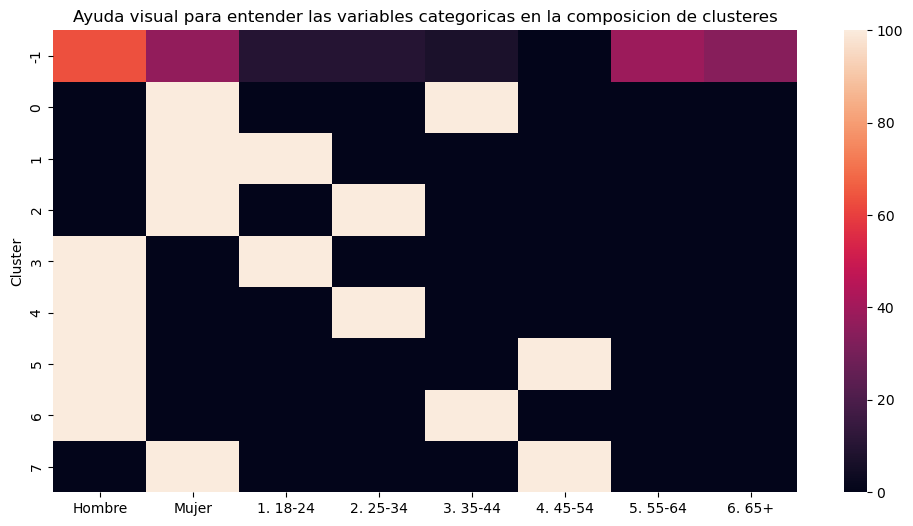

In [132]:
# Generar grupo por Genero
gender_counts = df_resultado_gower.groupby('Cluster')['Genero'].value_counts().unstack(fill_value=0)

# Calculo del total por cada cluster
gender_counts['Total'] = gender_counts.sum(axis=1)

# Calculo del porcentaje de cada categoria por cluster
gender_counts['Hombre'] = np.round((gender_counts['Hombre'] / gender_counts['Total']) * 100,1)
gender_counts['Mujer'] = np.round((gender_counts['Mujer'] / gender_counts['Total']) * 100,1)


# Generar grupo por rango de edad
age_range_counts = df_resultado_gower.groupby('Cluster')['rango_edades'].value_counts().unstack(fill_value=0)

# Calculo del total por cada cluster 
age_range_counts['Total'] = age_range_counts.sum(axis=1)

# Calculo de porcentaje de cada categoria por cluster
age_range_counts["1. 18-24"] = np.round(100* age_range_counts["1. 18-24"]/age_range_counts["Total"] , 1)
age_range_counts["2. 25-34"] = np.round(100* age_range_counts["2. 25-34"]/age_range_counts["Total"] , 1)
age_range_counts["3. 35-44"] = np.round(100* age_range_counts["3. 35-44"]/age_range_counts["Total"] , 1)
age_range_counts["4. 45-54"] = np.round(100* age_range_counts["4. 45-54"]/age_range_counts["Total"] , 1)
age_range_counts["5. 55-64"] = np.round(100* age_range_counts["5. 55-64"]/age_range_counts["Total"] , 1)
age_range_counts["6. 65+"] = np.round(100* age_range_counts["6. 65+"]/age_range_counts["Total"] , 1)


# Calculo de variables cuantitativas
categoricas_desc = df_resultado_gower.groupby("Cluster").agg({"Ingreso":"mean","Puntaje_Gasto":"mean"})


# Combinar los 3 reportes para obtener una unica visual
combined_stats = pd.concat([categoricas_desc,gender_counts.drop(columns="Total"), age_range_counts.drop(columns="Total")], axis=1)

display(combined_stats)

# Heatmap para ayudar visualmente a entender la composicion de los cluster

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(combined_stats.iloc[:,2:], ax=ax)
ax.set_title("Ayuda visual para entender las variables categoricas en la composicion de clusteres")

Al ver el resultado del agrupamiento con variables categoricas, vemos que ahora se identifican clusters definidos a partir de estas, a comparacion de los clusters anteriores se ha pedido en cierta manera la division natural que existia con ingresos y puntaje de Gasto, estas ultimas variables cuantitativas ya no son evidentes y por consiguiente su interpretacion debe darse comparando los valores propios con los de otros cluster, por ejemlpo el cluster 4 y 0 gastan en promedio mas que el resto, por lo que seran un cluster de gasto alto:

| Cluster | Género   | Edad       | Ingresos | Gasto promedio |
|---------|----------|------------|----------|----------------|
| **0**   | Mujeres  | 35-44 años | Altos    | Bajo           |
| **1**   | Mujeres  | 18-24 años | Bajo     | Alto           |
| **2**   | Mujeres  | 25-34 años | Alto     | Alto           |
| **3**   | Hombres  | 18-24 años | Bajo     | Alto           |
| **4**   | Hombres  | 25-34 años | Altos    | Alto           |
| **5**   | Hombres  | 45-54 años | Medio    | Bajo           |
| **6**   | Hombres  | 35-44 años | Alto     | Medio          |
| **7**   | Mujeres  | 45-54 años | Bajo     | Bajo           |


Para cada uno de estos clusters se pueden establecer las siguientes estrategias dependiendo sus comportamiento de ingresos y gasto promedio:

Ingresos                | Gasto promedio | Descripción                                                                                                                                               |
|----------------------|--------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| Medio  | Bajo      | Se pueden trabajar estrategias de profundización de clientes, analizando qué categorías de productos son las de mayor gasto, así se puede incentivar a los clientes para que consuman más de la tienda. |
| Alto   | Alto      | Es el grupo ideal ya que tienen altos ingresos y realizan alto gasto; no habría que incentivar el gasto, pero deben monitorearse para identificar posibles desplazamientos a otros clusters. Si esto ocurre, se deben pensar en estrategias de conservación. |
| Bajo   | Alto      | Son clientes que, aunque tienen ingresos bajos, están gastando alto. Para conservarlos, podrían recibir comunicaciones para aprovechar descuentos o promociones en la tienda. |
| Alto   | Bajo      | Clientes con alto ingreso y alto costo; debería incentivarse el gasto, tal vez con el mismo tratamiento del grupo anterior: comunicaciones para aprovechar descuentos o promociones. |
| Bajo   | Bajo      | Este grupo es el más complicado, ya que no cuentan con la capacidad para ahorrar. Para conservarlos, podrían ofrecerse programas de fidelización para que no sigan disminuyendo su consumo. |


Si bien la estrategia es la misma a la sugerida en puntos anteriores las nuevas dimensiones (Genero y Edad) abren la posibilidad de personalizar las comunicaciones, canales (por donde llegaran las ofertas) y las caracteristicas de los productos que se van a promocionar en cada uno, por ejemplo el canal por el que llega una oferta sera distinto para las personas jovenes que para las personas viejas; Asi mismo un producto ofertado para mujeres con altos ingresos sera distinto a uno para hombres con bajos ingresos.


Para los outliers se puede plantear asignarlos a un cluster con otra estrategia como **agglomerative clustering** o asignar una comunicacion generica para estos.